In [ ]:
import numpy as np
import pandas as pd
import os
import scipy
import matplotlib.pyplot as plt
import tensorflow as tf

!pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta
import seaborn as sns
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)
!apt-get install tarfile
import tarfile
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import contextlib
import lzma
import tarfile
import matplotlib.pyplot as plt

!pip install visualkeras
import visualkeras

drive.mount('/content/drive')

os.chdir('drive/MyDrive/HDA')

from utilis import *

!tar -xf "speech_recognition.tar.xz" -C "/content"

  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=88c3140fc4a61ede35e16327026865ac901f5ffbd3f710687ffd3367d320022d
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package tarfile
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 32.1 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:

%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/MyDrive
/content/drive
/content
/


**Preliminary Notes**

The code is divided in two blocks:
*   Analysis on standard dataset
*   Analysis on noisy dataset

Since the models are the same for each block, these are defined early in the notebook, as the early stopping criterion.
Each block have the same layout:

*   Model trainig
*   Training and validation curve
*   Model evalutaion on the test
*   Metrics calculation with confusion matrix

NB: all the notebook could be runned sequentially all at once, but I suggest to run it before with standard dataset, then reinitialize the session and run the analysis for noisy dataset, in order to not encounter any ram issue.

In this notebook at the end there is an experiment of an architecture implemented without dropout, this in order to assess if dropout layer increases performance.

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

def custom_res_block(X, kernel_size, n_filter):

    X_1=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out



def CNN_v3(input_shape, output_shape):
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(4,4), padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((3,3), strides=(2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.2)(X)

    X=custom_res_block(X, (2,3), 16)

    X=tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=128)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.2)(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model



def CNN_v2(input_shape, output_shape):
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(5,8), strides=(2,2),padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=custom_res_block(X, (5,5), 16)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Conv2D(24, (2,3))(X)
    X=tf.keras.layers.AveragePooling2D((2,3))(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Conv2D(32, (2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Conv2D(32, (1,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=256)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.Dropout(0.3)(X)

    X=tf.keras.layers.Dense(units=64)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model


def residual_block(X, filters, kernel_size, index):
    d=int(2**(np.trunc(index/3)))

    X_1=tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out


def resnet8(input_shape, output_shape):
    X_input = layers.Input(shape=input_shape)

    X=tf.keras.layers.Conv2D(19, kernel_size=(3,3),padding='same')(X_input)
    X=tf.keras.layers.AveragePooling2D((4,3))(X)

    for i in range(3):
      X=residual_block(X, filters=19, kernel_size=(3,3), index=i)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)
    X=tf.keras.layers.Flatten()(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model


In [ ]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

**Training models with Log Filterbank**

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set,train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True,cache_file_value='train_cache', type='logfbank')
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='logfbank')
test_set,test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, shuffle=False ,type='logfbank', testing=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 99, 19)           190       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 10, 33, 19)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 33, 19)           3268      ['average_pooling2d[0][0]'

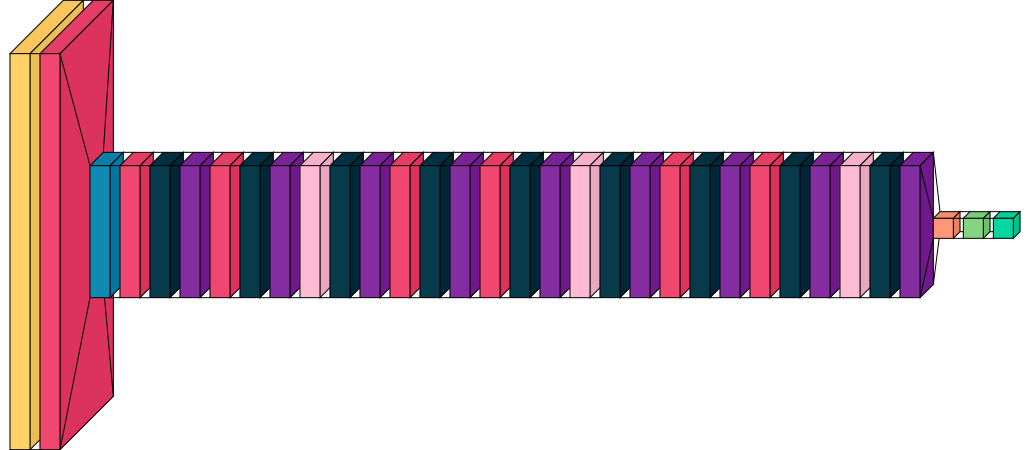

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

resnet8_m=resnet8(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(resnet8_m.summary())
visualkeras.layered_view(resnet8_m)

In [ ]:
resnet8_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_resnet8_m=resnet8_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 401s 310ms/step - loss: 2.6307 - sparse_categorical_accuracy: 0.3229 - val_loss: 2.4358 - val_sparse_categorical_accuracy: 0.2971
Epoch 2/25
497/497 [==============================] - 78s 156ms/step - loss: 1.4577 - sparse_categorical_accuracy: 0.6180 - val_loss: 1.5862 - val_sparse_categorical_accuracy: 0.5376
Epoch 3/25
497/497 [==============================] - 75s 152ms/step - loss: 0.9351 - sparse_categorical_accuracy: 0.7545 - val_loss: 1.1469 - val_sparse_categorical_accuracy: 0.6797
Epoch 4/25
497/497 [==============================] - 80s 161ms/step - loss: 0.7131 - sparse_categorical_accuracy: 0.8087 - val_loss: 0.7428 - val_sparse_categorical_accuracy: 0.7964
Epoch 5/25
497/497 [==============================] - 75s 151ms/step - loss: 0.5971 - sparse_categorical_accuracy: 0.8352 - val_loss: 0.7311 - val_sparse_categorical_accuracy: 0.7945
Epoch 6/25
497/497 [==============================] - 81s 163ms/step - loss: 0.5300 

In [ ]:
#resnet8_m.save("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('renset8_logf'))

resnet8_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('renset8_logf'))

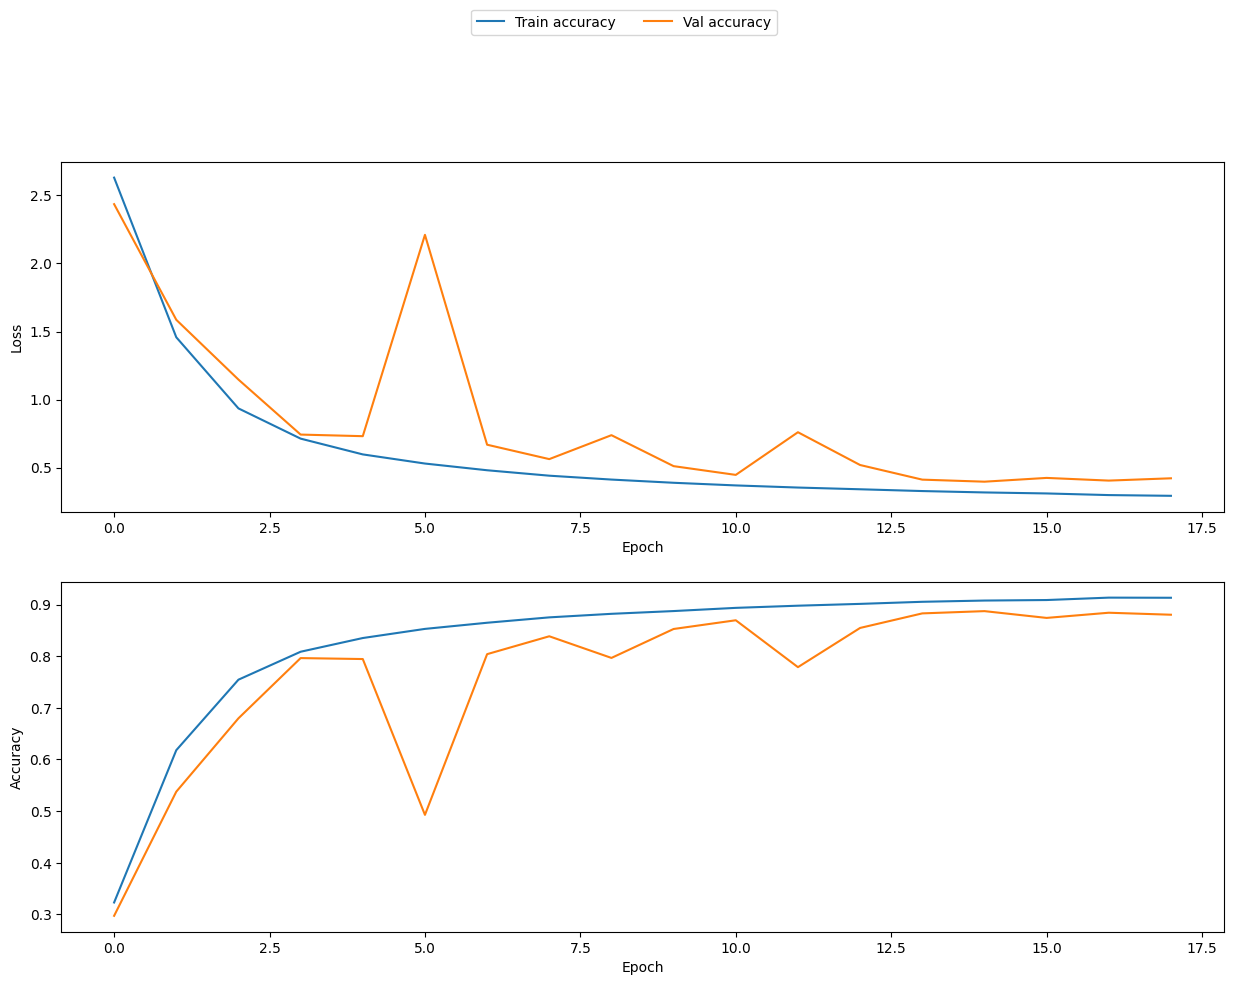

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_resnet8_m.history['loss'], label='Train loss')
axis[0].plot(history_resnet8_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_resnet8_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_resnet8_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=resnet8_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{resnet8_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 7s 41ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.884301,0.868582,0.884377,0.884301,0.878069,0.889465,0.884301,0.893536,0.884301,0.884301,0.868582,resnet8_m


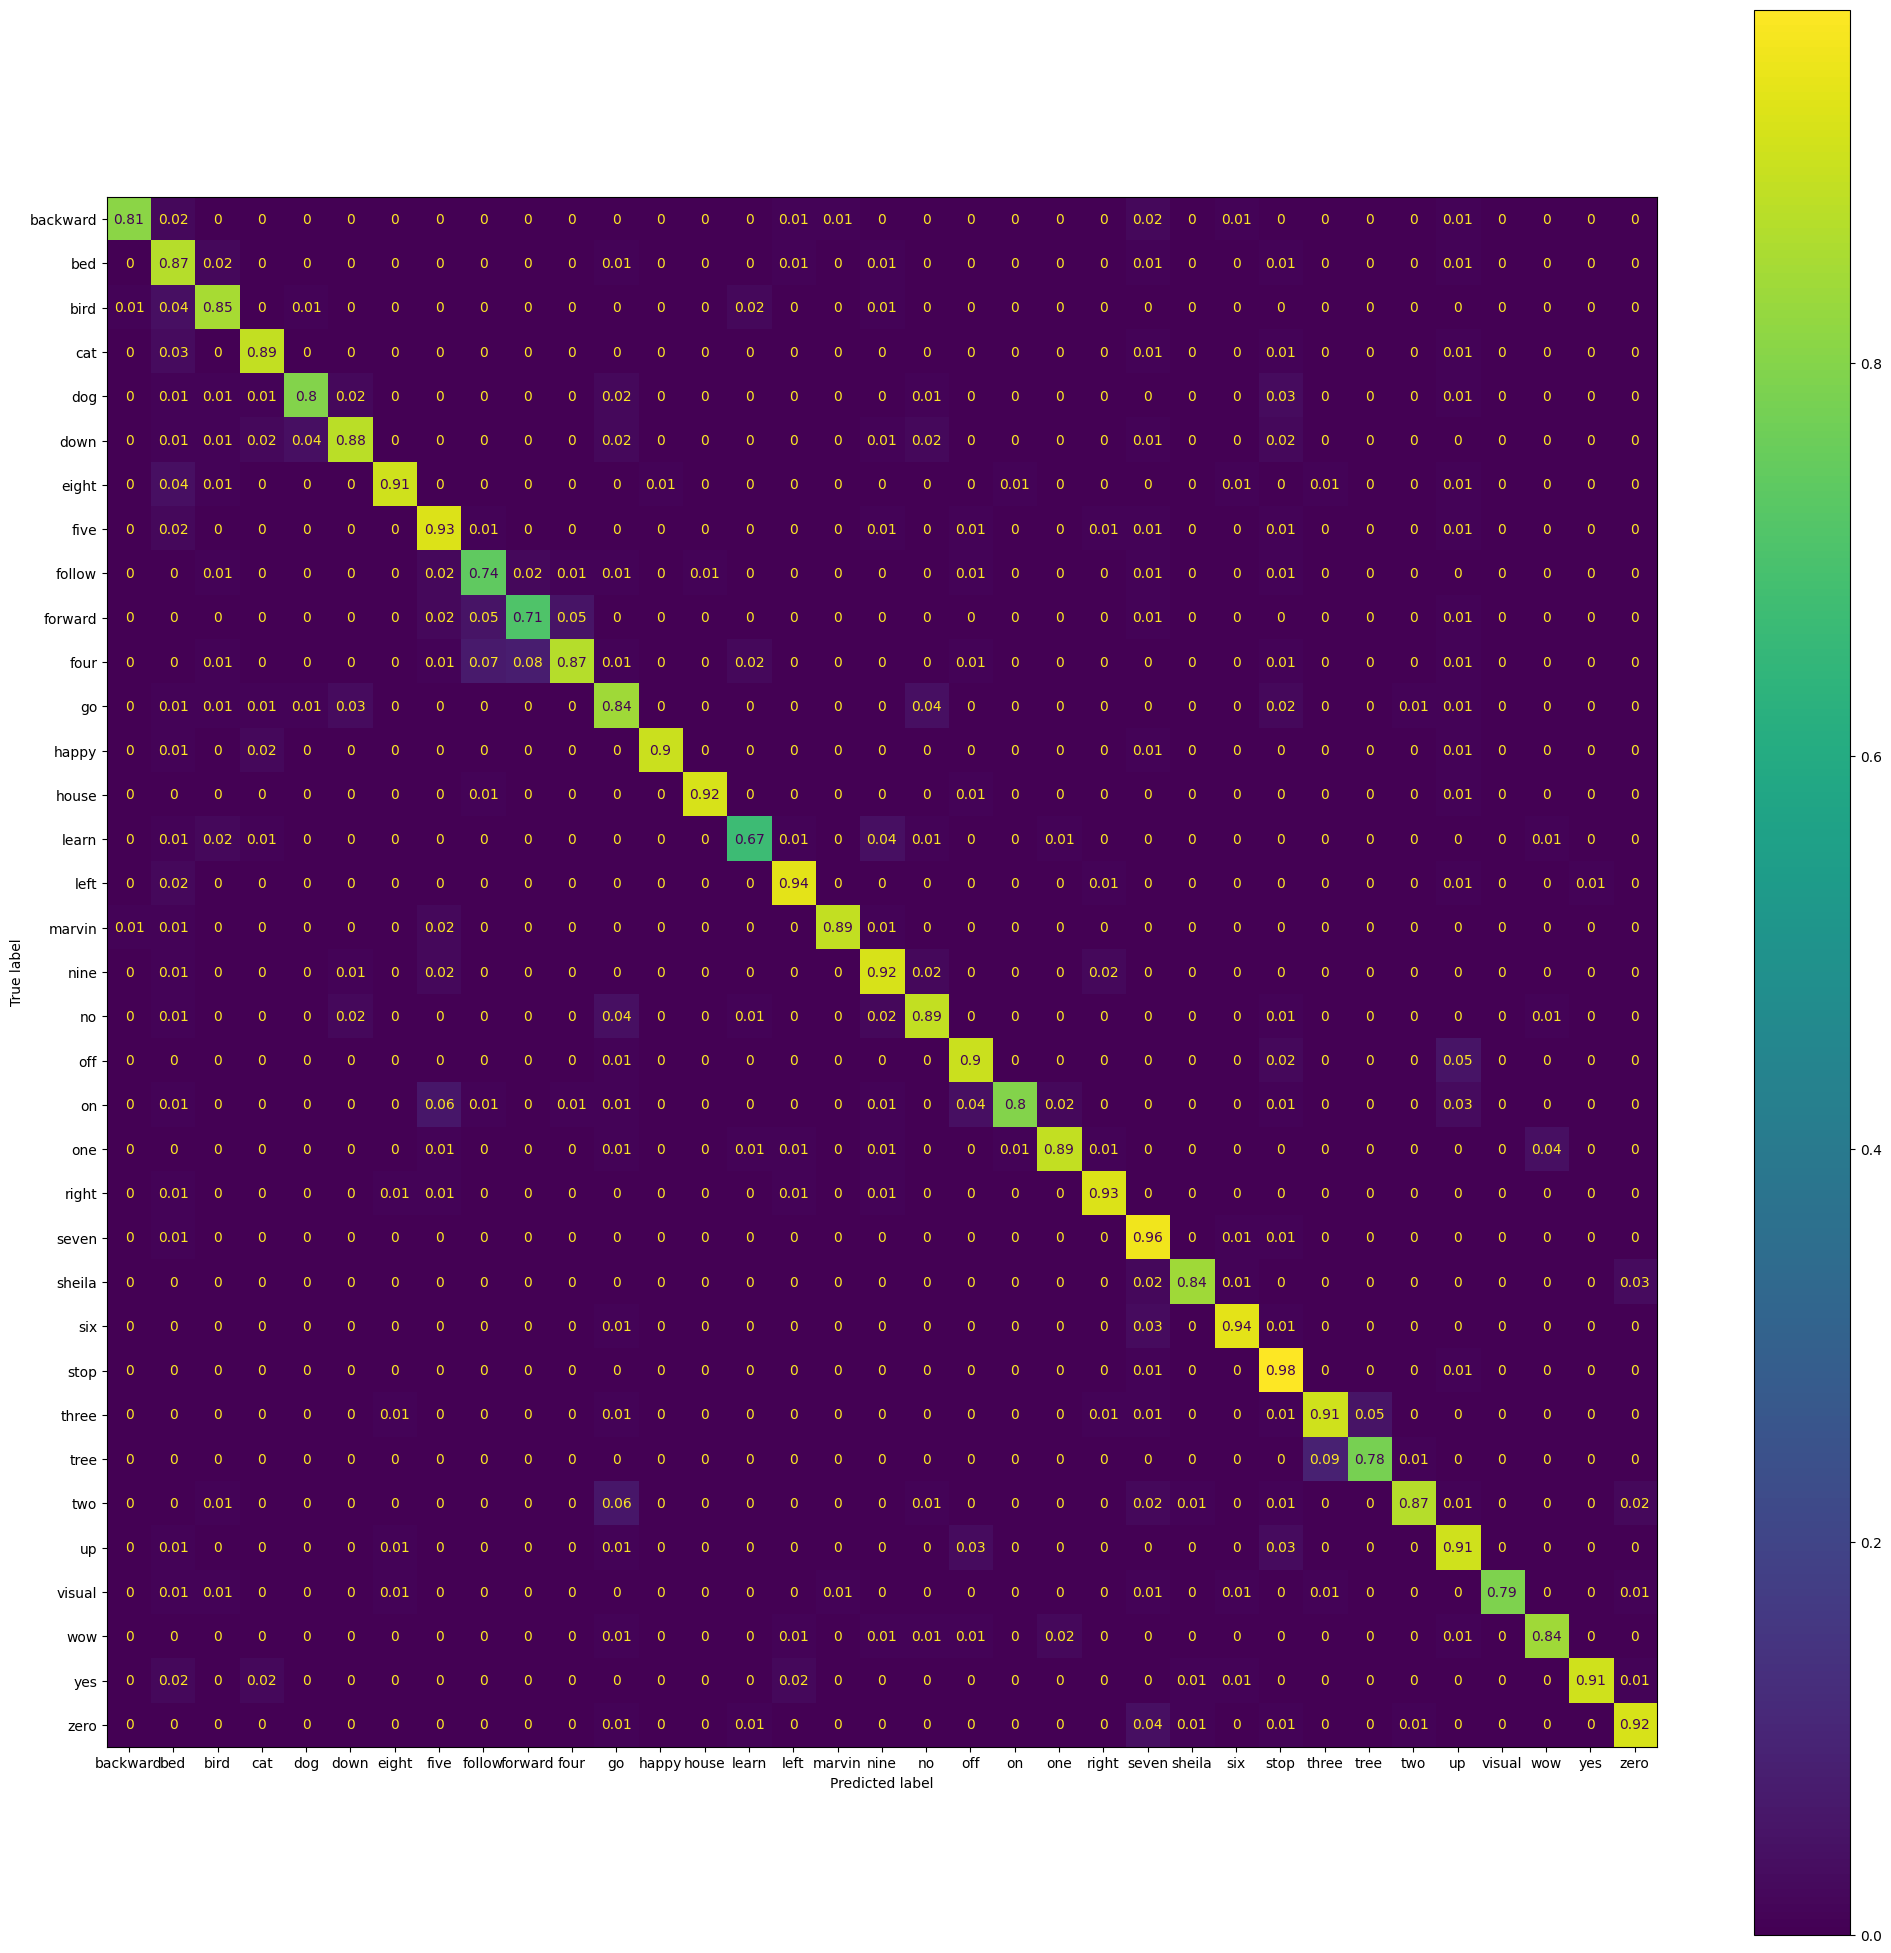

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 20, 50, 8)            328       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 20, 50, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 20, 50, 8)            32        ['activation[0][0]']          
 Normalization)                                                                               

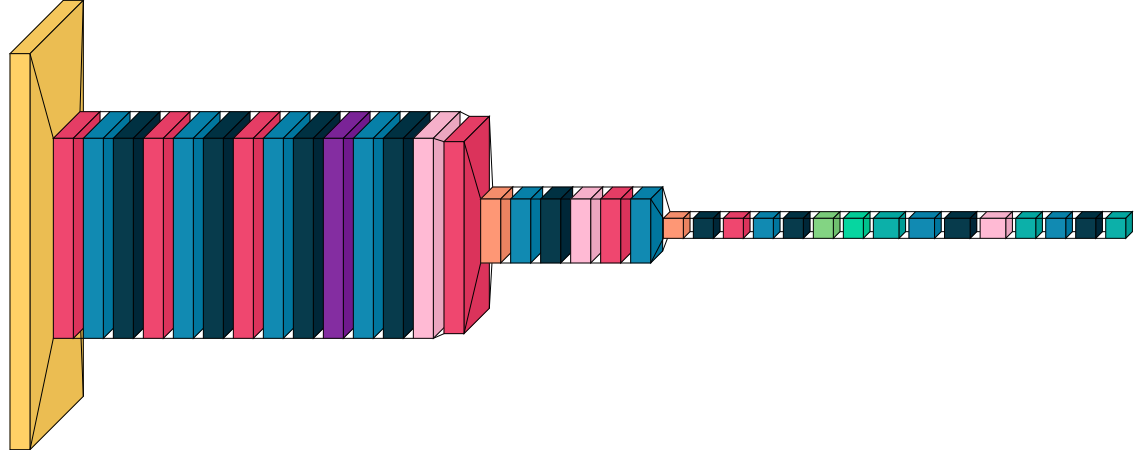

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CNN_v2 = CNN_v2(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v2.summary())
visualkeras.layered_view(CNN_v2)

In [ ]:
CNN_v2.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v2=CNN_v2.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 415s 347ms/step - loss: 2.0459 - sparse_categorical_accuracy: 0.4297 - val_loss: 1.2249 - val_sparse_categorical_accuracy: 0.6660
Epoch 2/25
497/497 [==============================] - 94s 189ms/step - loss: 0.9188 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.7973
Epoch 3/25
497/497 [==============================] - 94s 189ms/step - loss: 0.7154 - sparse_categorical_accuracy: 0.7868 - val_loss: 0.6878 - val_sparse_categorical_accuracy: 0.8013
Epoch 4/25
497/497 [==============================] - 98s 198ms/step - loss: 0.6258 - sparse_categorical_accuracy: 0.8120 - val_loss: 0.5196 - val_sparse_categorical_accuracy: 0.8424
Epoch 5/25
497/497 [==============================] - 98s 197ms/step - loss: 0.5678 - sparse_categorical_accuracy: 0.8265 - val_loss: 0.5310 - val_sparse_categorical_accuracy: 0.8349
Epoch 6/25
497/497 [==============================] - 98s 198ms/step - loss: 0.5285 

In [ ]:
#CNN_v2.save("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CNN_v2_logf'))
CNN_v2=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CNN_v2_logf'))

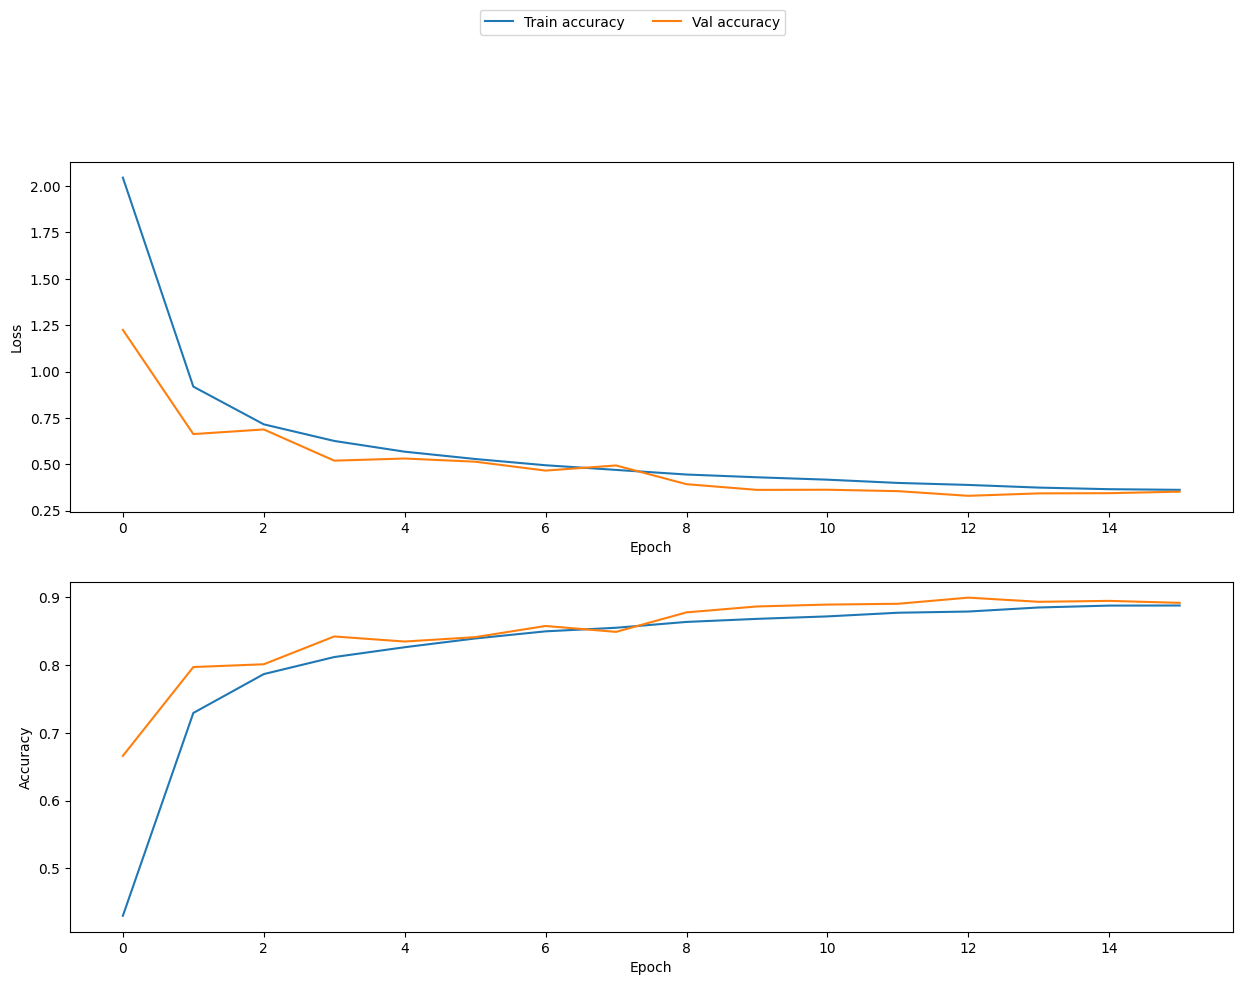

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v2.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v2.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v2.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v2.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score


pred=CNN_v2.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v2=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 5s 27ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.884301,0.868582,0.884377,0.884301,0.878069,0.889465,0.884301,0.893536,0.884301,0.884301,0.868582,resnet8_m
1,0.894080,0.887959,0.894548,0.894080,0.889254,0.896912,0.894080,0.892389,0.894080,0.894080,0.887959,CNN_v2


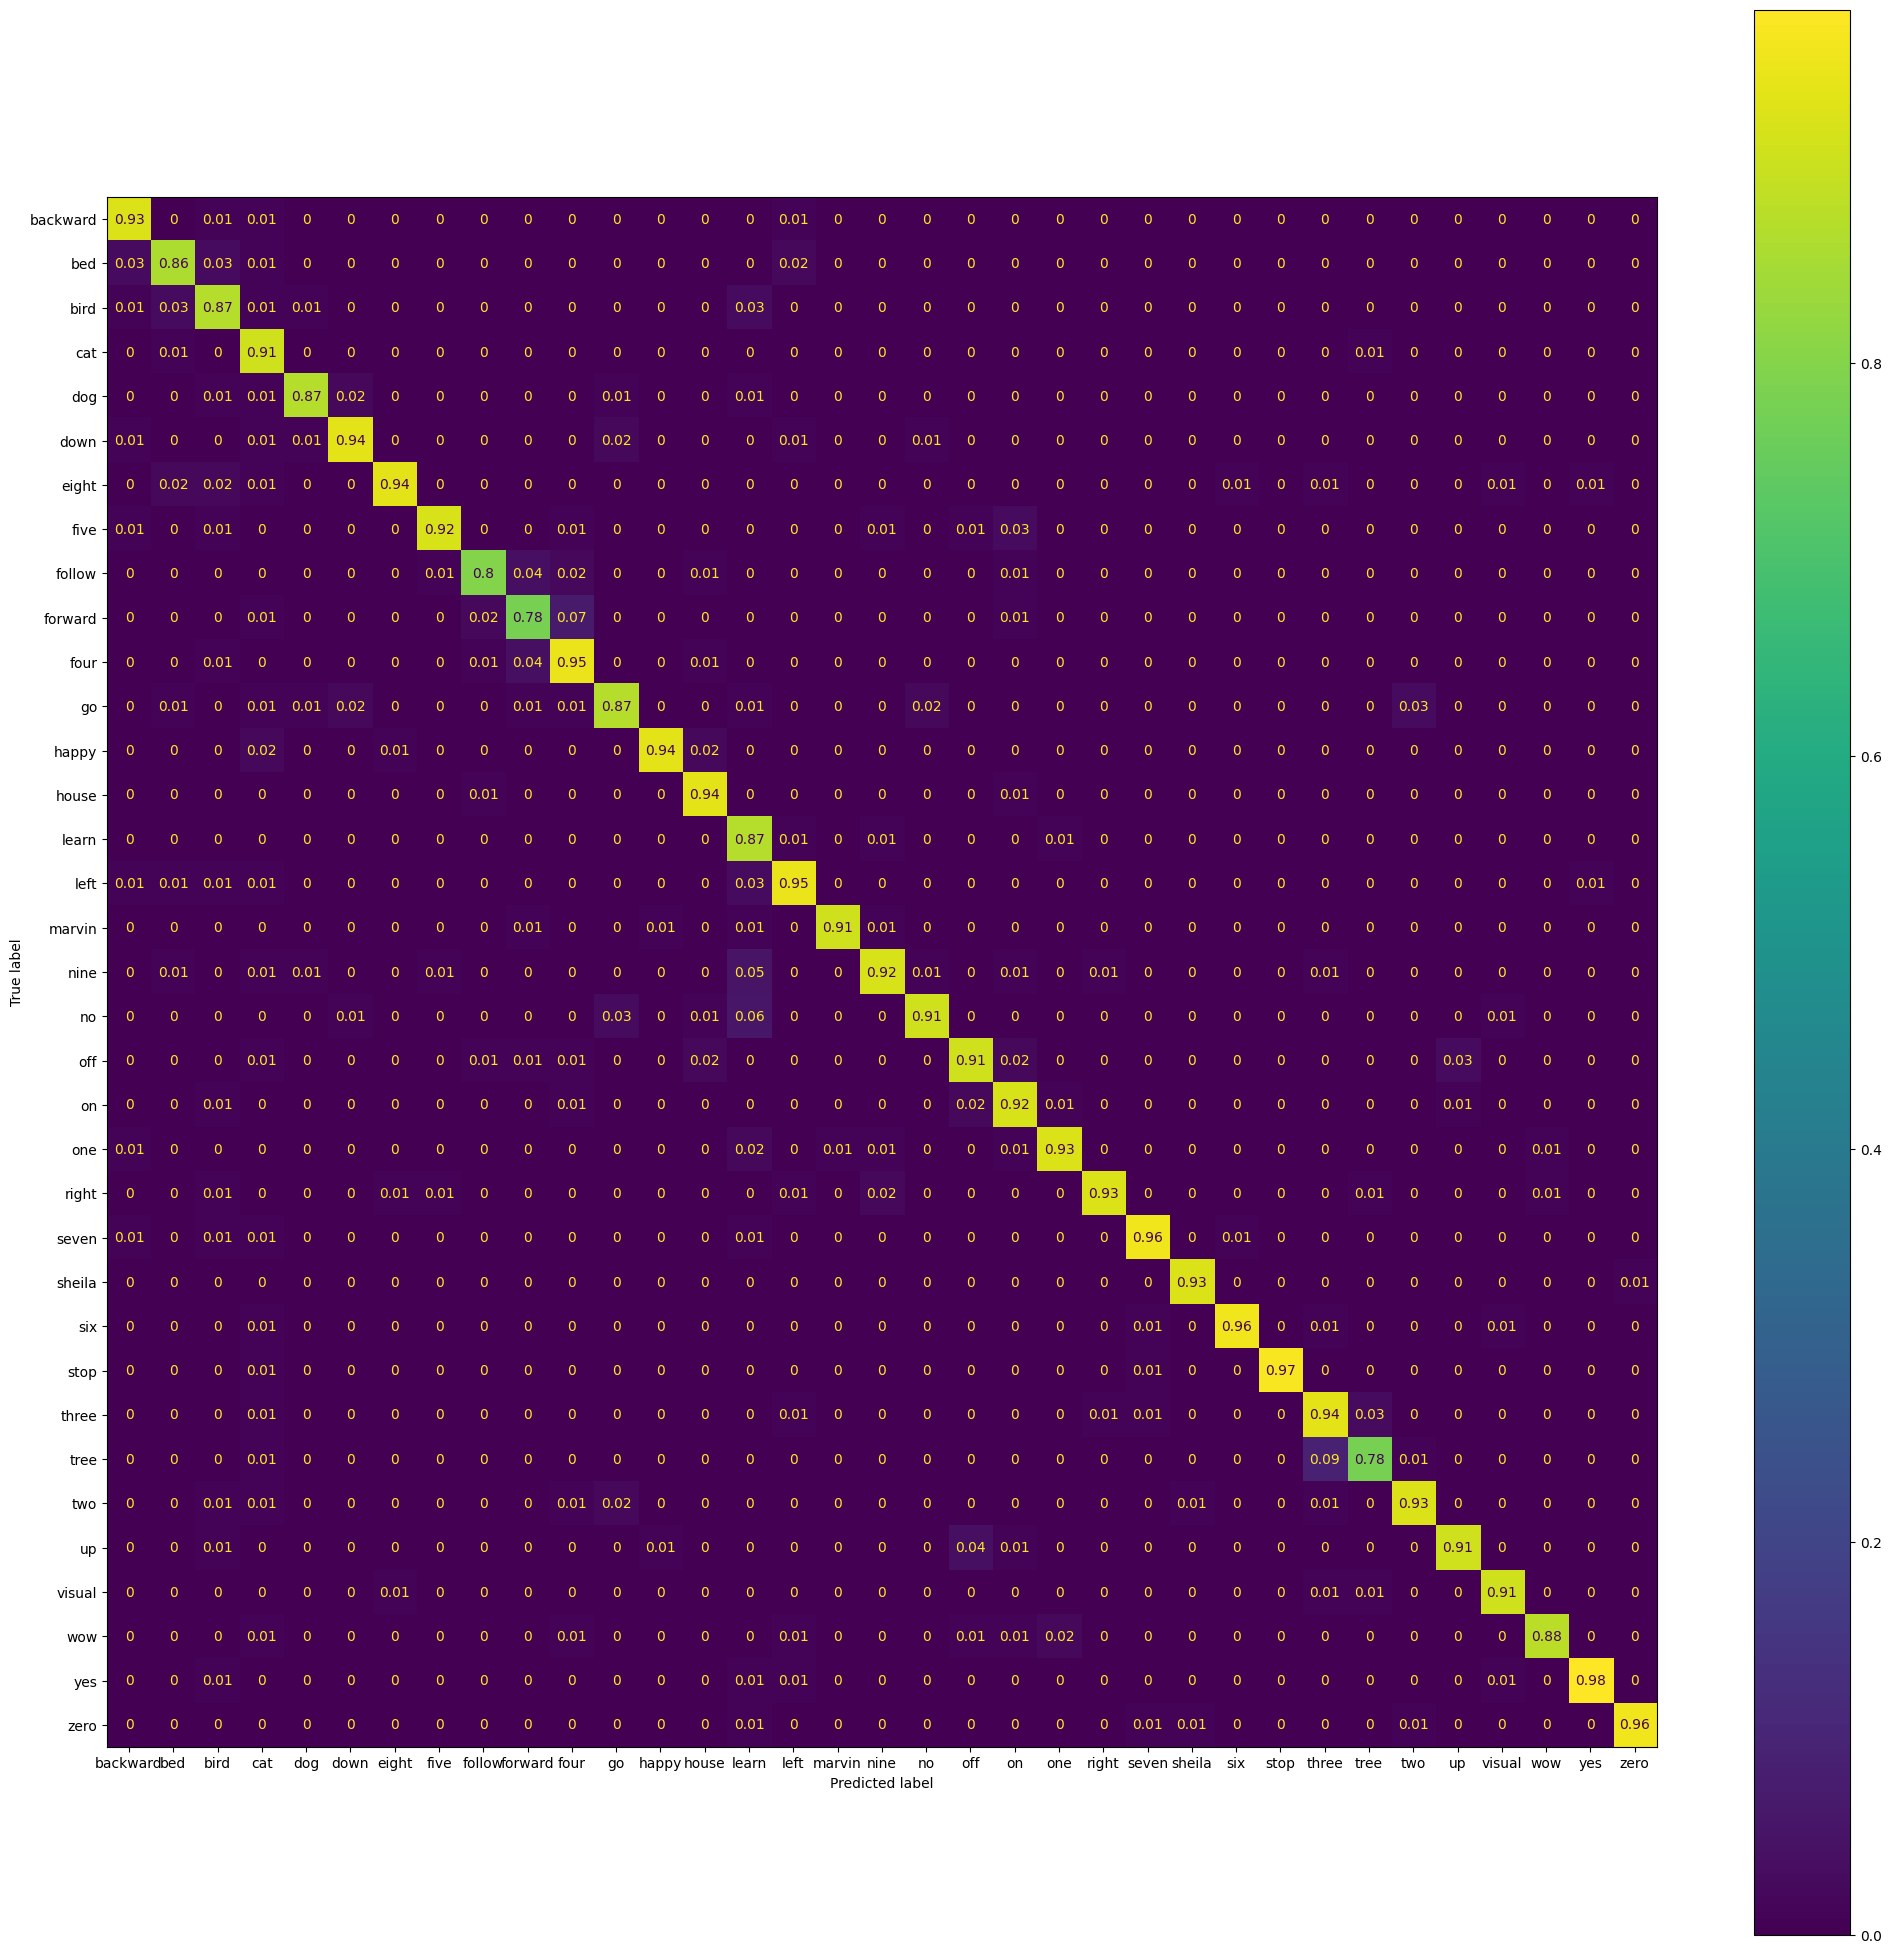

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 99, 8)            136       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 40, 99, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 average_pooling2d (Average  (None, 19, 33, 8)            0         ['activation[0][0]']          
 Pooling2D)                                                                                   

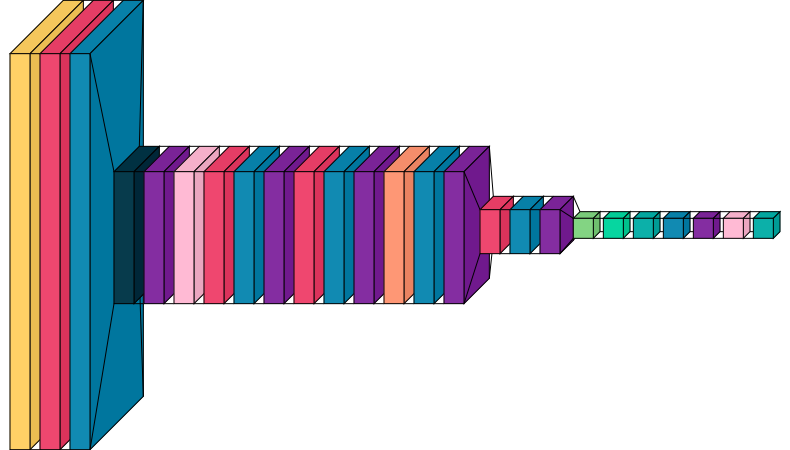

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CNN_v3_m=CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())
visualkeras.layered_view(CNN_v3_m)

In [ ]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v3=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 74s 137ms/step - loss: 2.7626 - sparse_categorical_accuracy: 0.2505 - val_loss: 2.3858 - val_sparse_categorical_accuracy: 0.3028
Epoch 2/25
497/497 [==============================] - 68s 137ms/step - loss: 1.4684 - sparse_categorical_accuracy: 0.5744 - val_loss: 1.4064 - val_sparse_categorical_accuracy: 0.5935
Epoch 3/25
497/497 [==============================] - 76s 152ms/step - loss: 1.0694 - sparse_categorical_accuracy: 0.6856 - val_loss: 1.0151 - val_sparse_categorical_accuracy: 0.7010
Epoch 4/25
497/497 [==============================] - 70s 141ms/step - loss: 0.8949 - sparse_categorical_accuracy: 0.7326 - val_loss: 0.8646 - val_sparse_categorical_accuracy: 0.7411
Epoch 5/25
497/497 [==============================] - 67s 135ms/step - loss: 0.8050 - sparse_categorical_accuracy: 0.7597 - val_loss: 0.6692 - val_sparse_categorical_accuracy: 0.7992
Epoch 6/25
497/497 [==============================] - 74s 148ms/step - loss: 0.7439 -

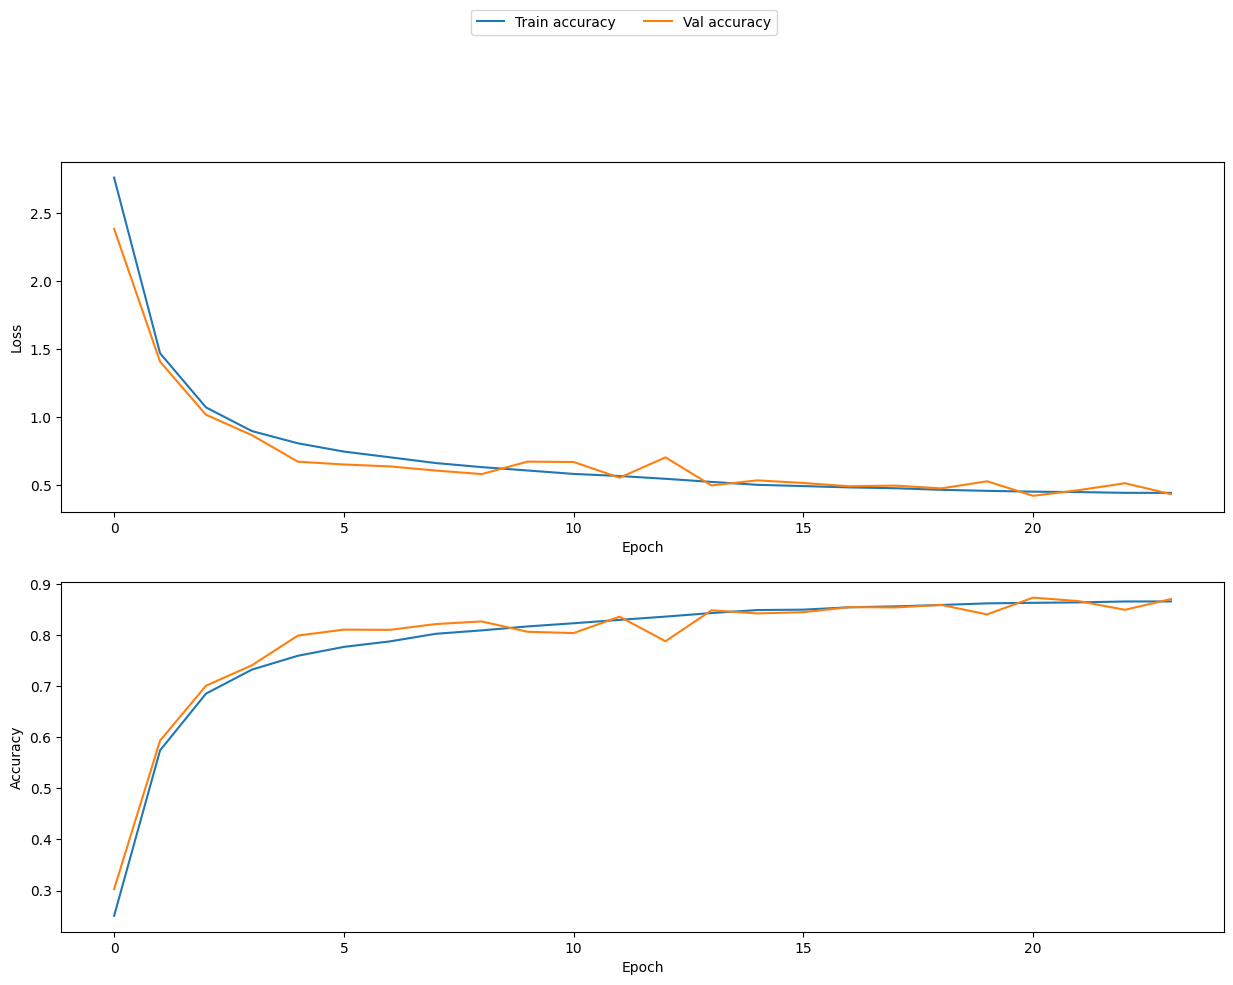

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v3.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
#CNN_v3_m.save("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CNN_v3_logf'))
CNN_v3_m=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/normal_dataset/{}".format('CNN_v3_logf'))

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))



166/166 [==============================] - 7s 44ms/step


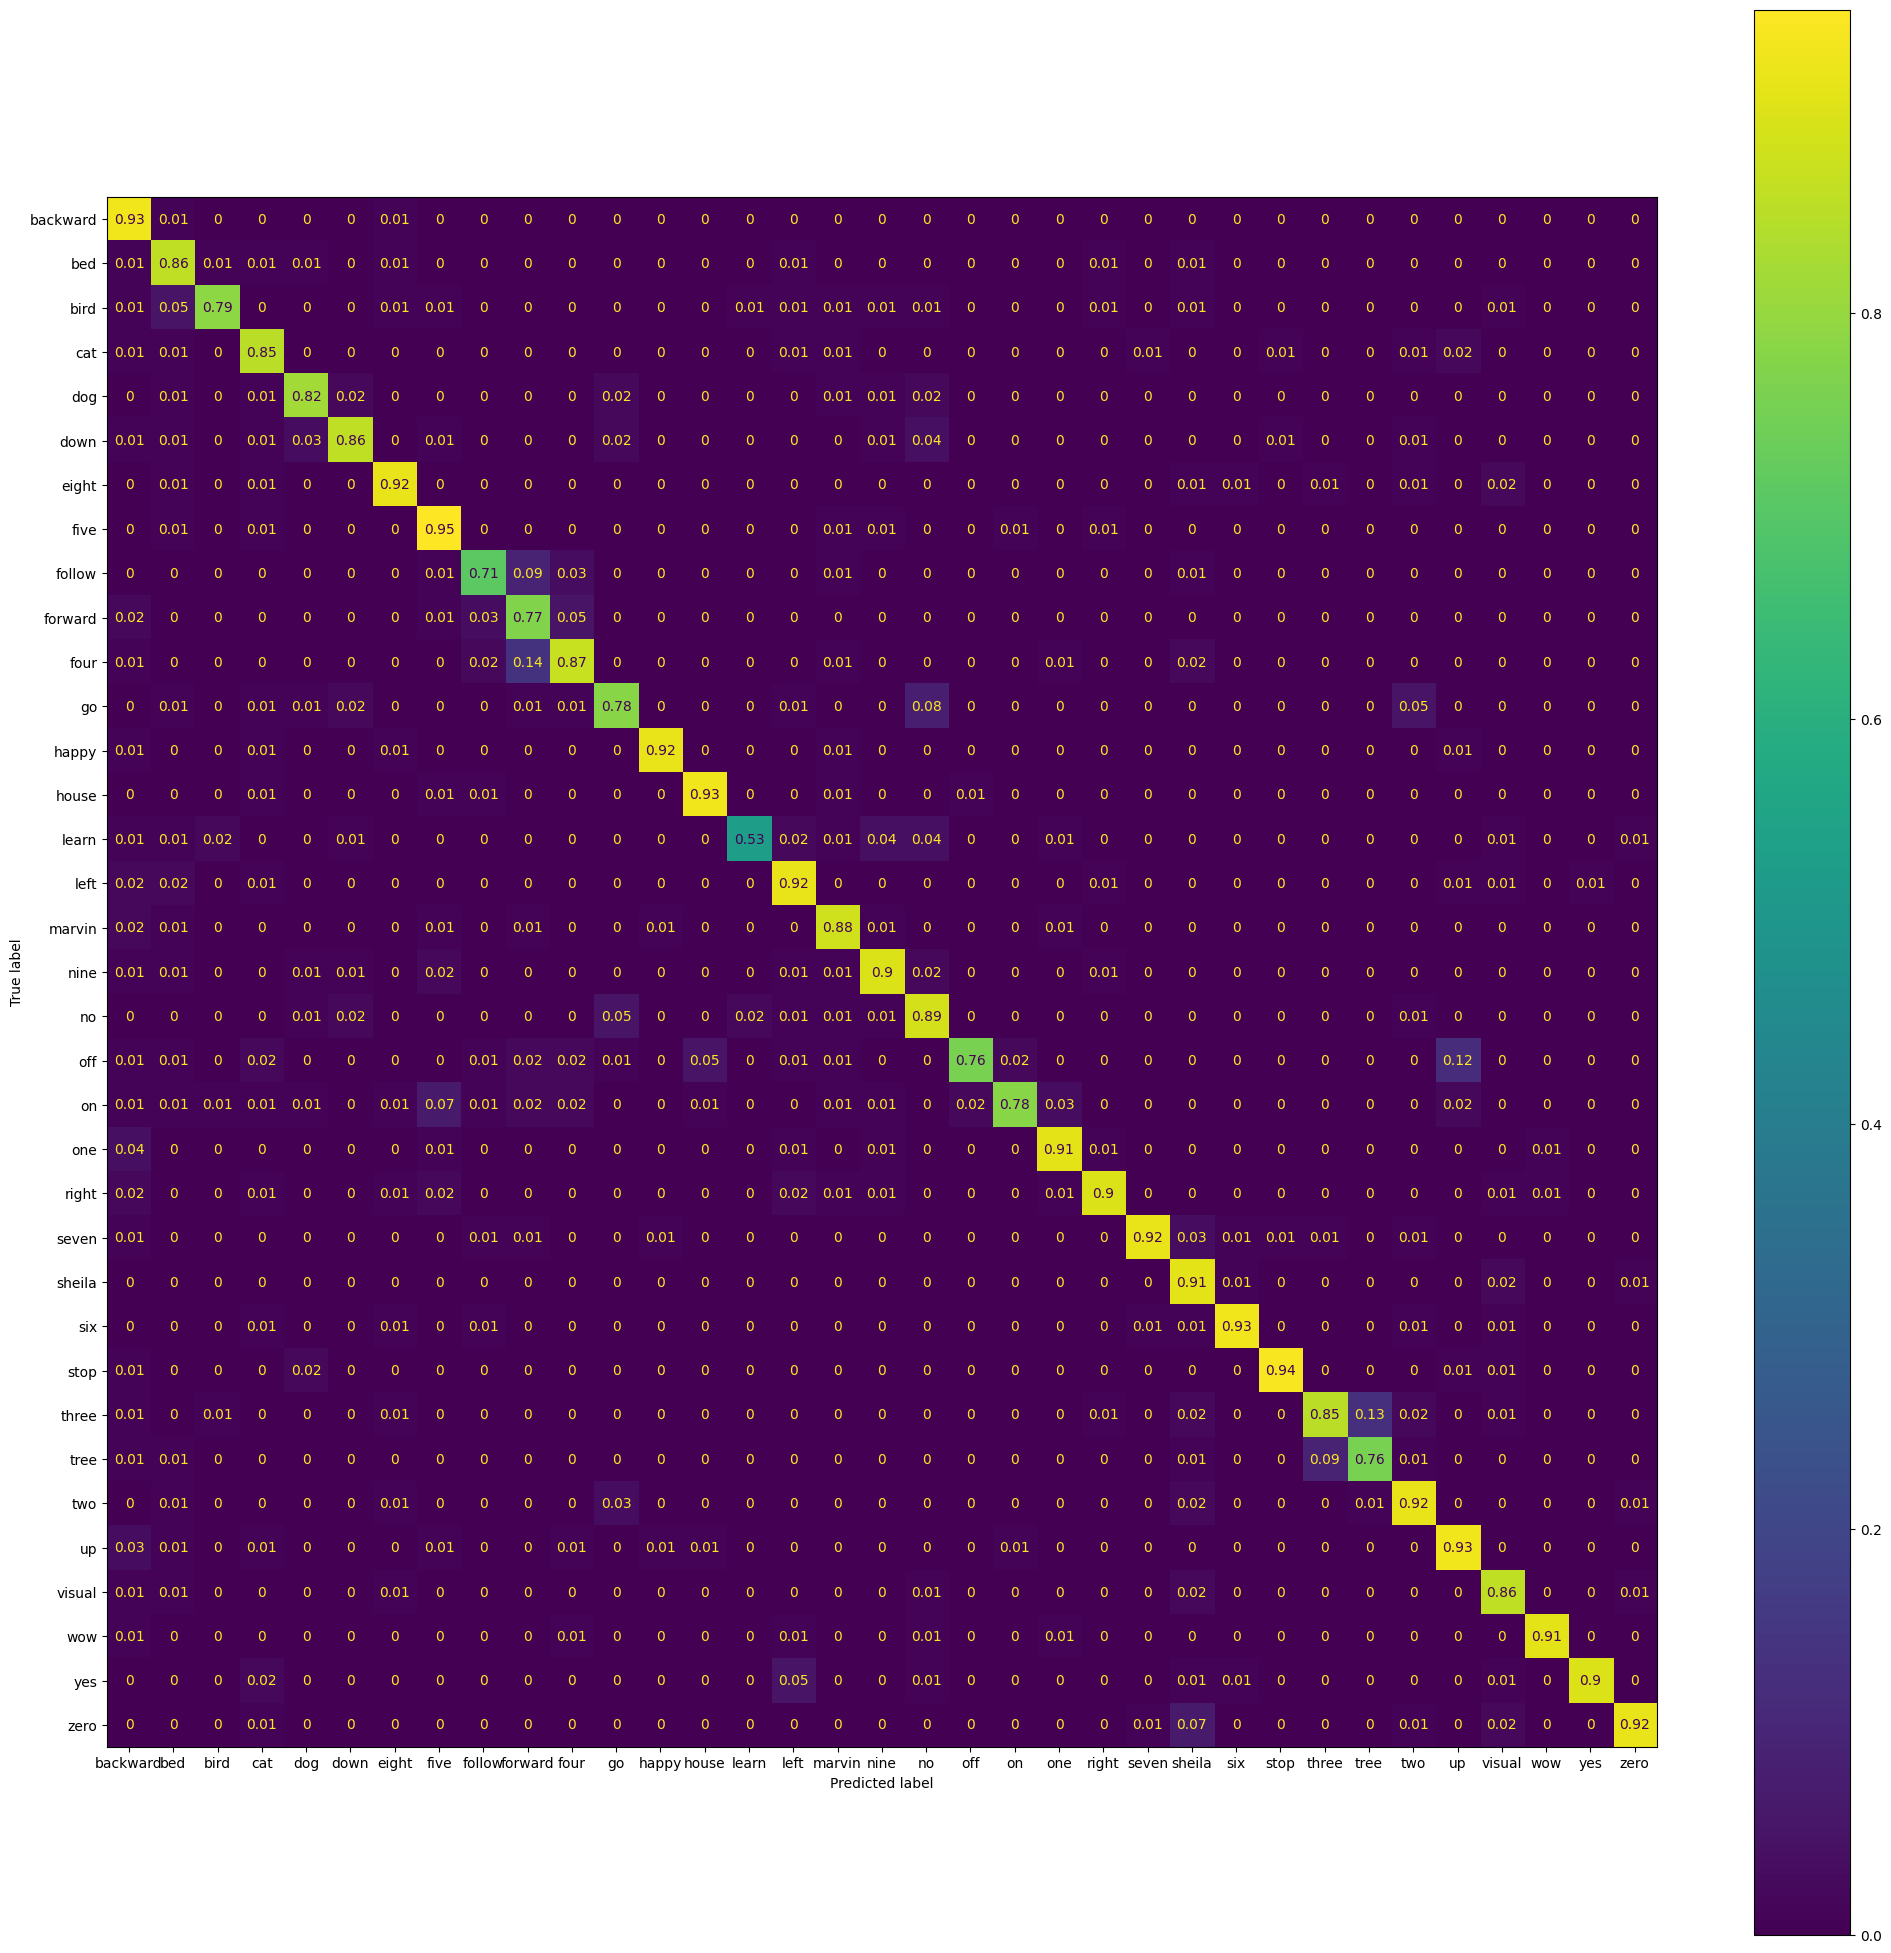

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.884301,0.868582,0.884377,0.884301,0.878069,0.889465,0.884301,0.893536,0.884301,0.884301,0.868582,resnet8_m
1,0.894080,0.887959,0.894548,0.894080,0.889254,0.896912,0.894080,0.892389,0.894080,0.894080,0.887959,CNN_v2
2,0.875136,0.862936,0.874688,0.875136,0.864335,0.879671,0.875136,0.872577,0.875136,0.875136,0.862936,CNN_v3_m


**Training Models with noised Log Filterbanks**

In [ ]:
del perform, train_set, train_set_label, validation_set, validation_set_label, test_set, test_set_label,
del history_CNN_v2, CNN_v2, CNN_v1, history_CNN_v1

tf.keras.backend.clear_session()
gc.collect()


In [ ]:
import gc
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import EarlyStopping, Callback

class ClearMemory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        k.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
clear_memory = ClearMemory()

callbacks = [early_stopping, clear_memory]

In [ ]:
df=pd.DataFrame([(k, i) for k, v in browse_directory().items() for i in v],columns=['key_id', 'ids'])

#train_mask, validation_mask = split(df, 0.6, 0.20)

train_mask=list(np.loadtxt("content/drive/MyDrive/HDA/training_mask.txt"))
validation_mask=list(np.loadtxt("content/drive/MyDrive/HDA/validation_mask.txt"))

batch_size=128
out_class=len(label_list)

train_set,train_set_label = create_dataset(df['ids'].iloc[train_mask], df['key_id'].iloc[train_mask], batch_size, shuffle=True,cache_file_value='train_cache', type='logfbank', input_noise=True)
validation_set, validation_set_label = create_dataset(df['ids'].iloc[validation_mask], df['key_id'].iloc[validation_mask], batch_size, shuffle=True , cache_file_value='validation_cache', type='logfbank', input_noise=True)
test_set,test_set_label = create_dataset(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)], df['key_id'].iloc[~df.index.isin(train_mask+validation_mask)], batch_size, cache_file_value='test_cache', repeat=False, shuffle=False ,type='logfbank', testing=True, input_noise=True)

train_steps = int(np.ceil(len(df['ids'].iloc[train_mask]) / batch_size))
validation_steps = int(np.ceil(len(df['ids'].iloc[validation_mask]) / batch_size))
test_steps = int(np.ceil(len(df['ids'].iloc[~df.index.isin(train_mask+validation_mask)]) / batch_size))



Shuffled dataset
Shuffled dataset


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 99, 8)            136       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 40, 99, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 average_pooling2d (Average  (None, 19, 33, 8)            0         ['activation[0][0]']          
 Pooling2D)                                                                                   

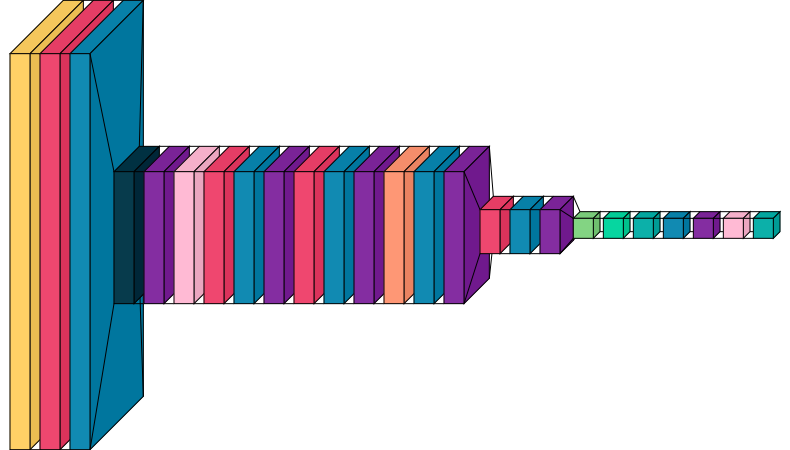

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CNN_v3_m=CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())
visualkeras.layered_view(CNN_v3_m)

In [ ]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v3_m=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps,callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 493s 407ms/step - loss: 2.8362 - sparse_categorical_accuracy: 0.2008 - val_loss: 3.2594 - val_sparse_categorical_accuracy: 0.1206
Epoch 2/25
497/497 [==============================] - 73s 147ms/step - loss: 1.9195 - sparse_categorical_accuracy: 0.4298 - val_loss: 2.0117 - val_sparse_categorical_accuracy: 0.4001
Epoch 3/25
497/497 [==============================] - 73s 147ms/step - loss: 1.5981 - sparse_categorical_accuracy: 0.5219 - val_loss: 2.2270 - val_sparse_categorical_accuracy: 0.3902
Epoch 4/25
497/497 [==============================] - 68s 137ms/step - loss: 1.4542 - sparse_categorical_accuracy: 0.5643 - val_loss: 2.0545 - val_sparse_categorical_accuracy: 0.4084
Epoch 5/25
497/497 [==============================] - 69s 139ms/step - loss: 1.3596 - sparse_categorical_accuracy: 0.5894 - val_loss: 1.1944 - val_sparse_categorical_accuracy: 0.6396
Epoch 6/25
497/497 [==============================] - 70s 140ms/step - loss: 1.2844 

In [ ]:
CNN_v3_m.save("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('CNN_v3_logf_noisy'))
#base_CNN_trad_fpool3=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('CNN_v1_logf'))

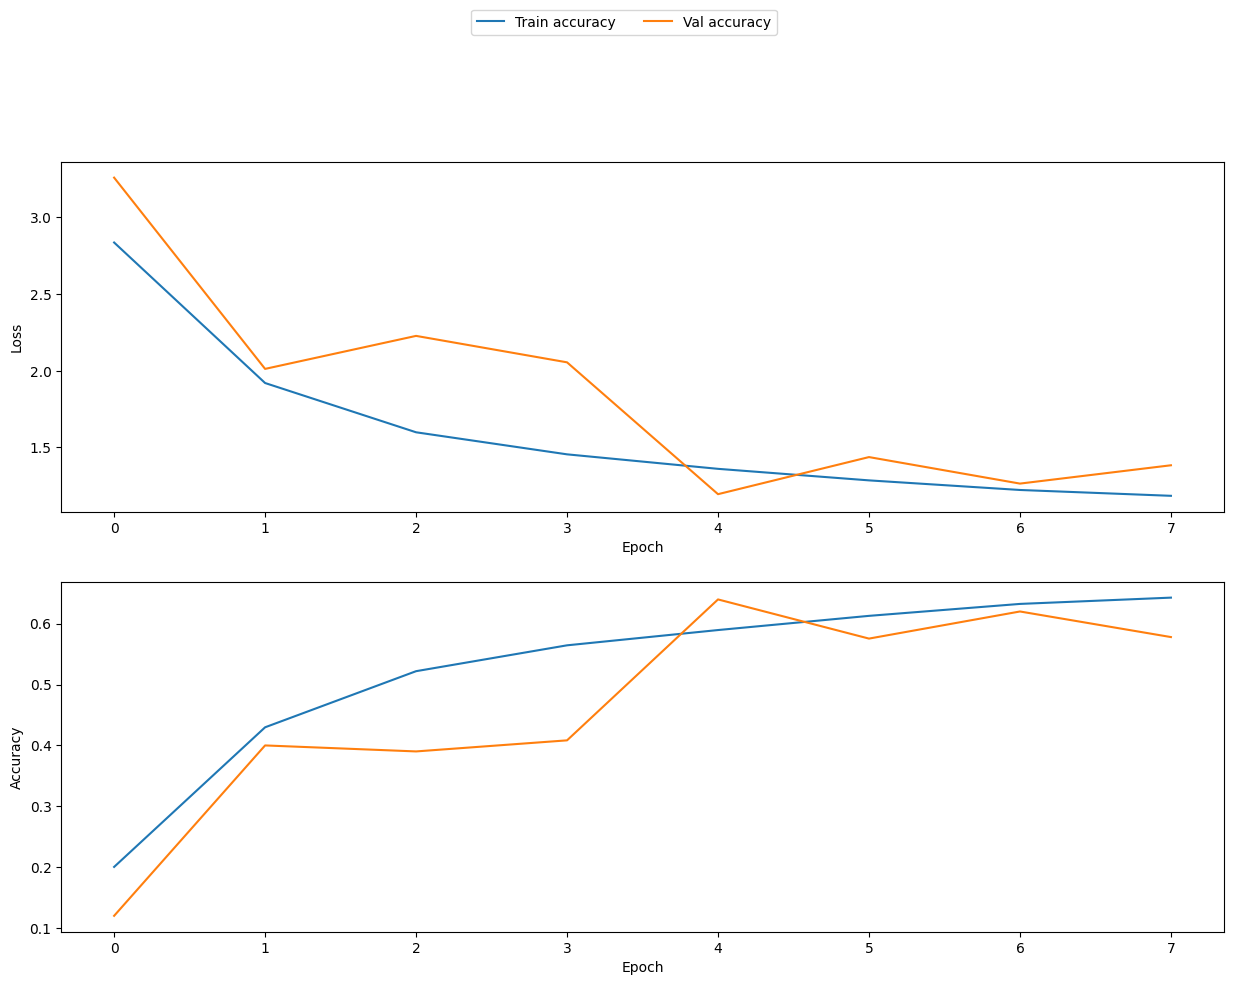

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))

axis[0].plot(history_CNN_v3_m.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v3_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v3_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v3_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')
plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 107s 646ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.640195,0.621359,0.63829,0.640195,0.628662,0.659183,0.640195,0.658575,0.640195,0.640195,0.621359,CNN_v3_m


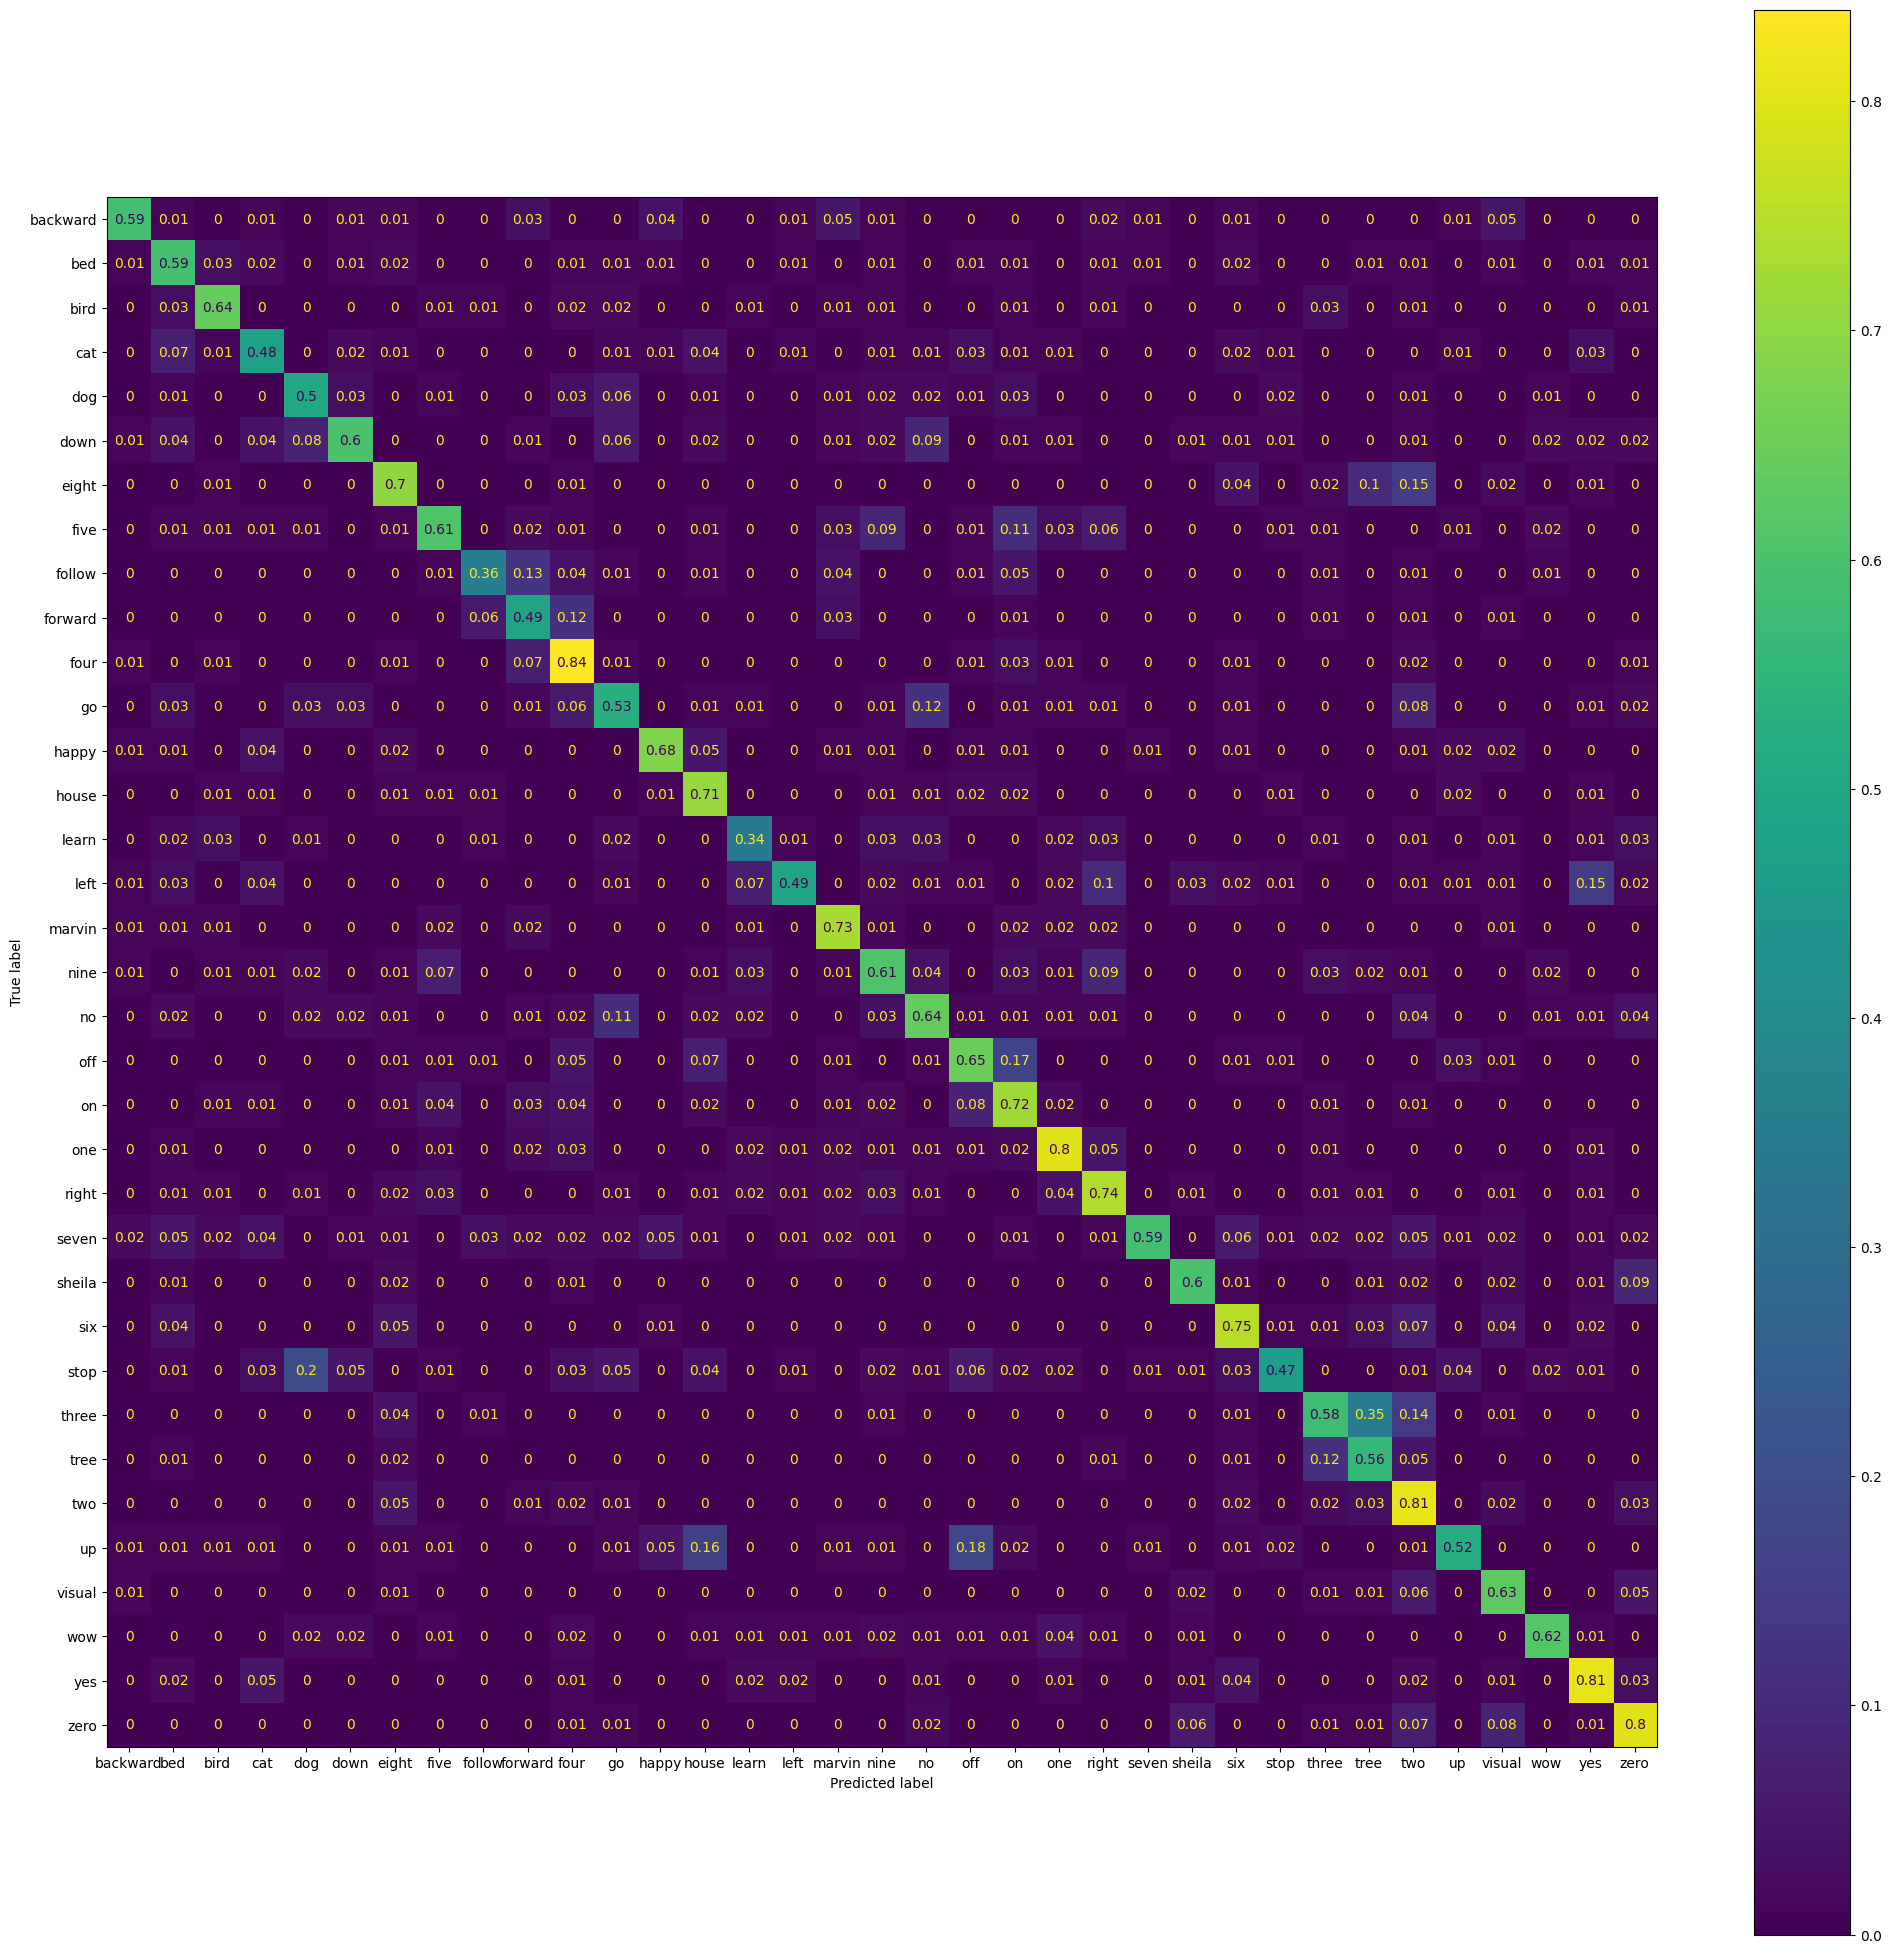

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 20, 50, 8)            328       ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 20, 50, 8)            0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 20, 50, 8)            32        ['activation[0][0]']          
 Normalization)                                                                               

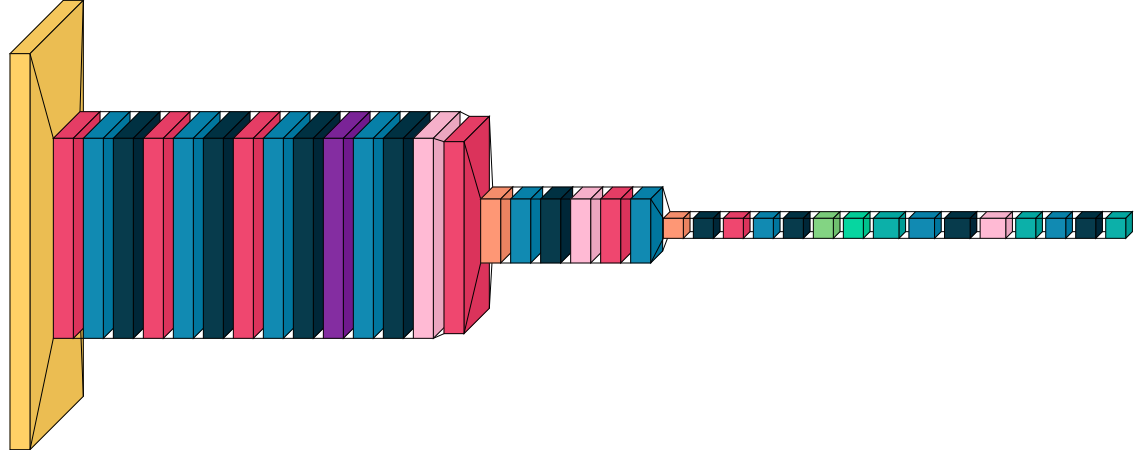

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CNN_v2 = CNN_v2(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v2.summary())
visualkeras.layered_view(CNN_v2)

In [ ]:
CNN_v2.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_CNN_v2=CNN_v2.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 98s 192ms/step - loss: 2.4757 - sparse_categorical_accuracy: 0.2896 - val_loss: 2.8303 - val_sparse_categorical_accuracy: 0.2474
Epoch 2/25
497/497 [==============================] - 96s 193ms/step - loss: 1.4142 - sparse_categorical_accuracy: 0.5723 - val_loss: 1.9814 - val_sparse_categorical_accuracy: 0.4423
Epoch 3/25
497/497 [==============================] - 109s 219ms/step - loss: 1.1262 - sparse_categorical_accuracy: 0.6567 - val_loss: 1.6470 - val_sparse_categorical_accuracy: 0.5499
Epoch 4/25
497/497 [==============================] - 95s 191ms/step - loss: 0.9949 - sparse_categorical_accuracy: 0.6950 - val_loss: 2.8879 - val_sparse_categorical_accuracy: 0.3836
Epoch 5/25
497/497 [==============================] - 95s 191ms/step - loss: 0.9245 - sparse_categorical_accuracy: 0.7175 - val_loss: 1.0206 - val_sparse_categorical_accuracy: 0.6925
Epoch 6/25
497/497 [==============================] - 99s 198ms/step - loss: 0.8646 

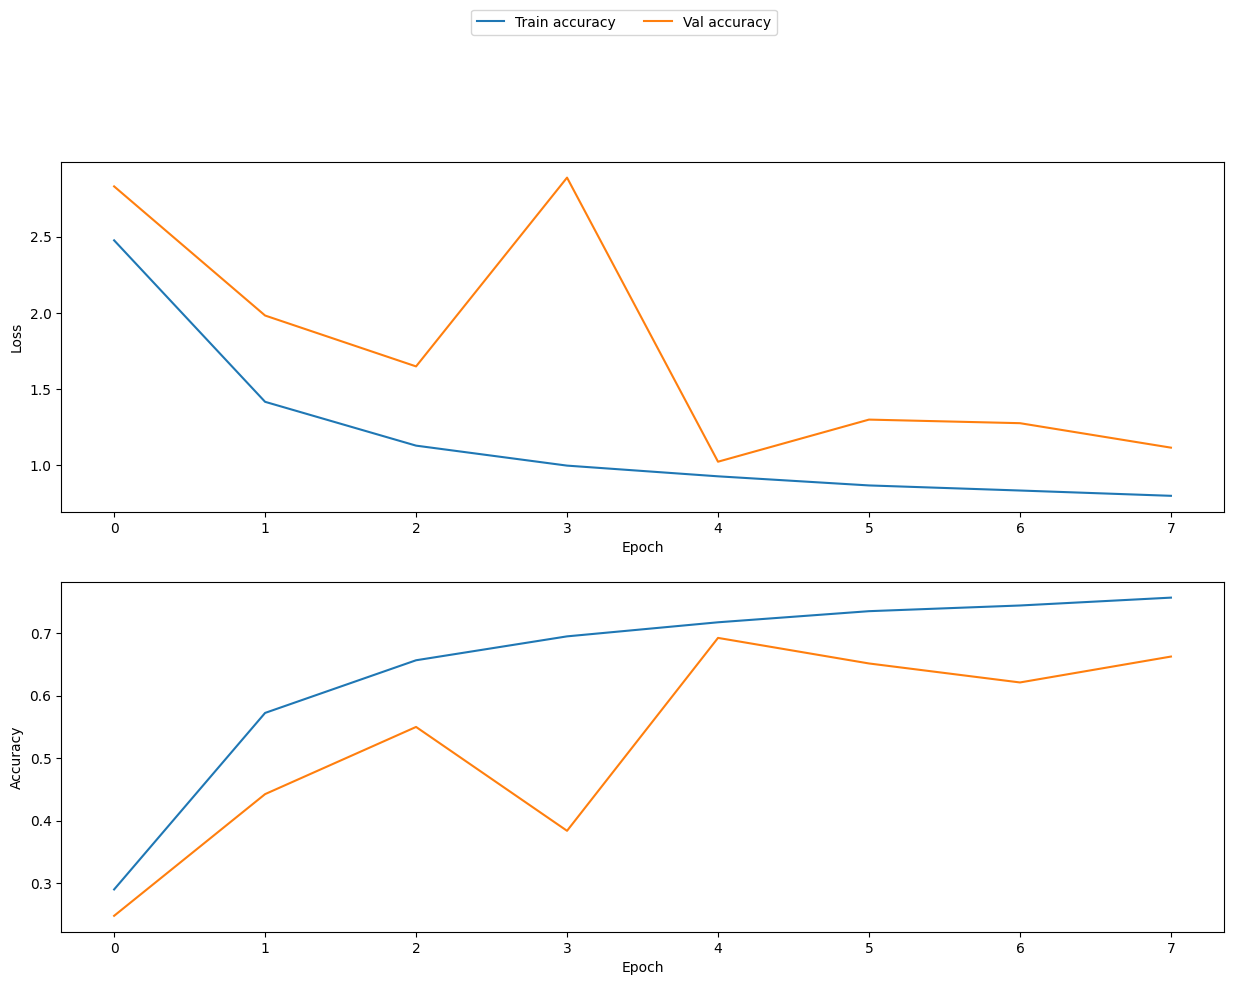

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_CNN_v2.history['loss'], label='Train loss')
axis[0].plot(history_CNN_v2.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_CNN_v2.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_CNN_v2.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
CNN_v2.save("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('CNN_v2_logf_noisy'))
#CNN_v2=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('CNN_v2_logf'))

In [ ]:

pred=CNN_v2.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v2=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 6s 38ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.640195,0.621359,0.638290,0.640195,0.628662,0.659183,0.640195,0.658575,0.640195,0.640195,0.621359,CNN_v3_m
1,0.690273,0.670744,0.694701,0.690273,0.685278,0.737047,0.690273,0.737675,0.690273,0.690273,0.670744,CNN_v2


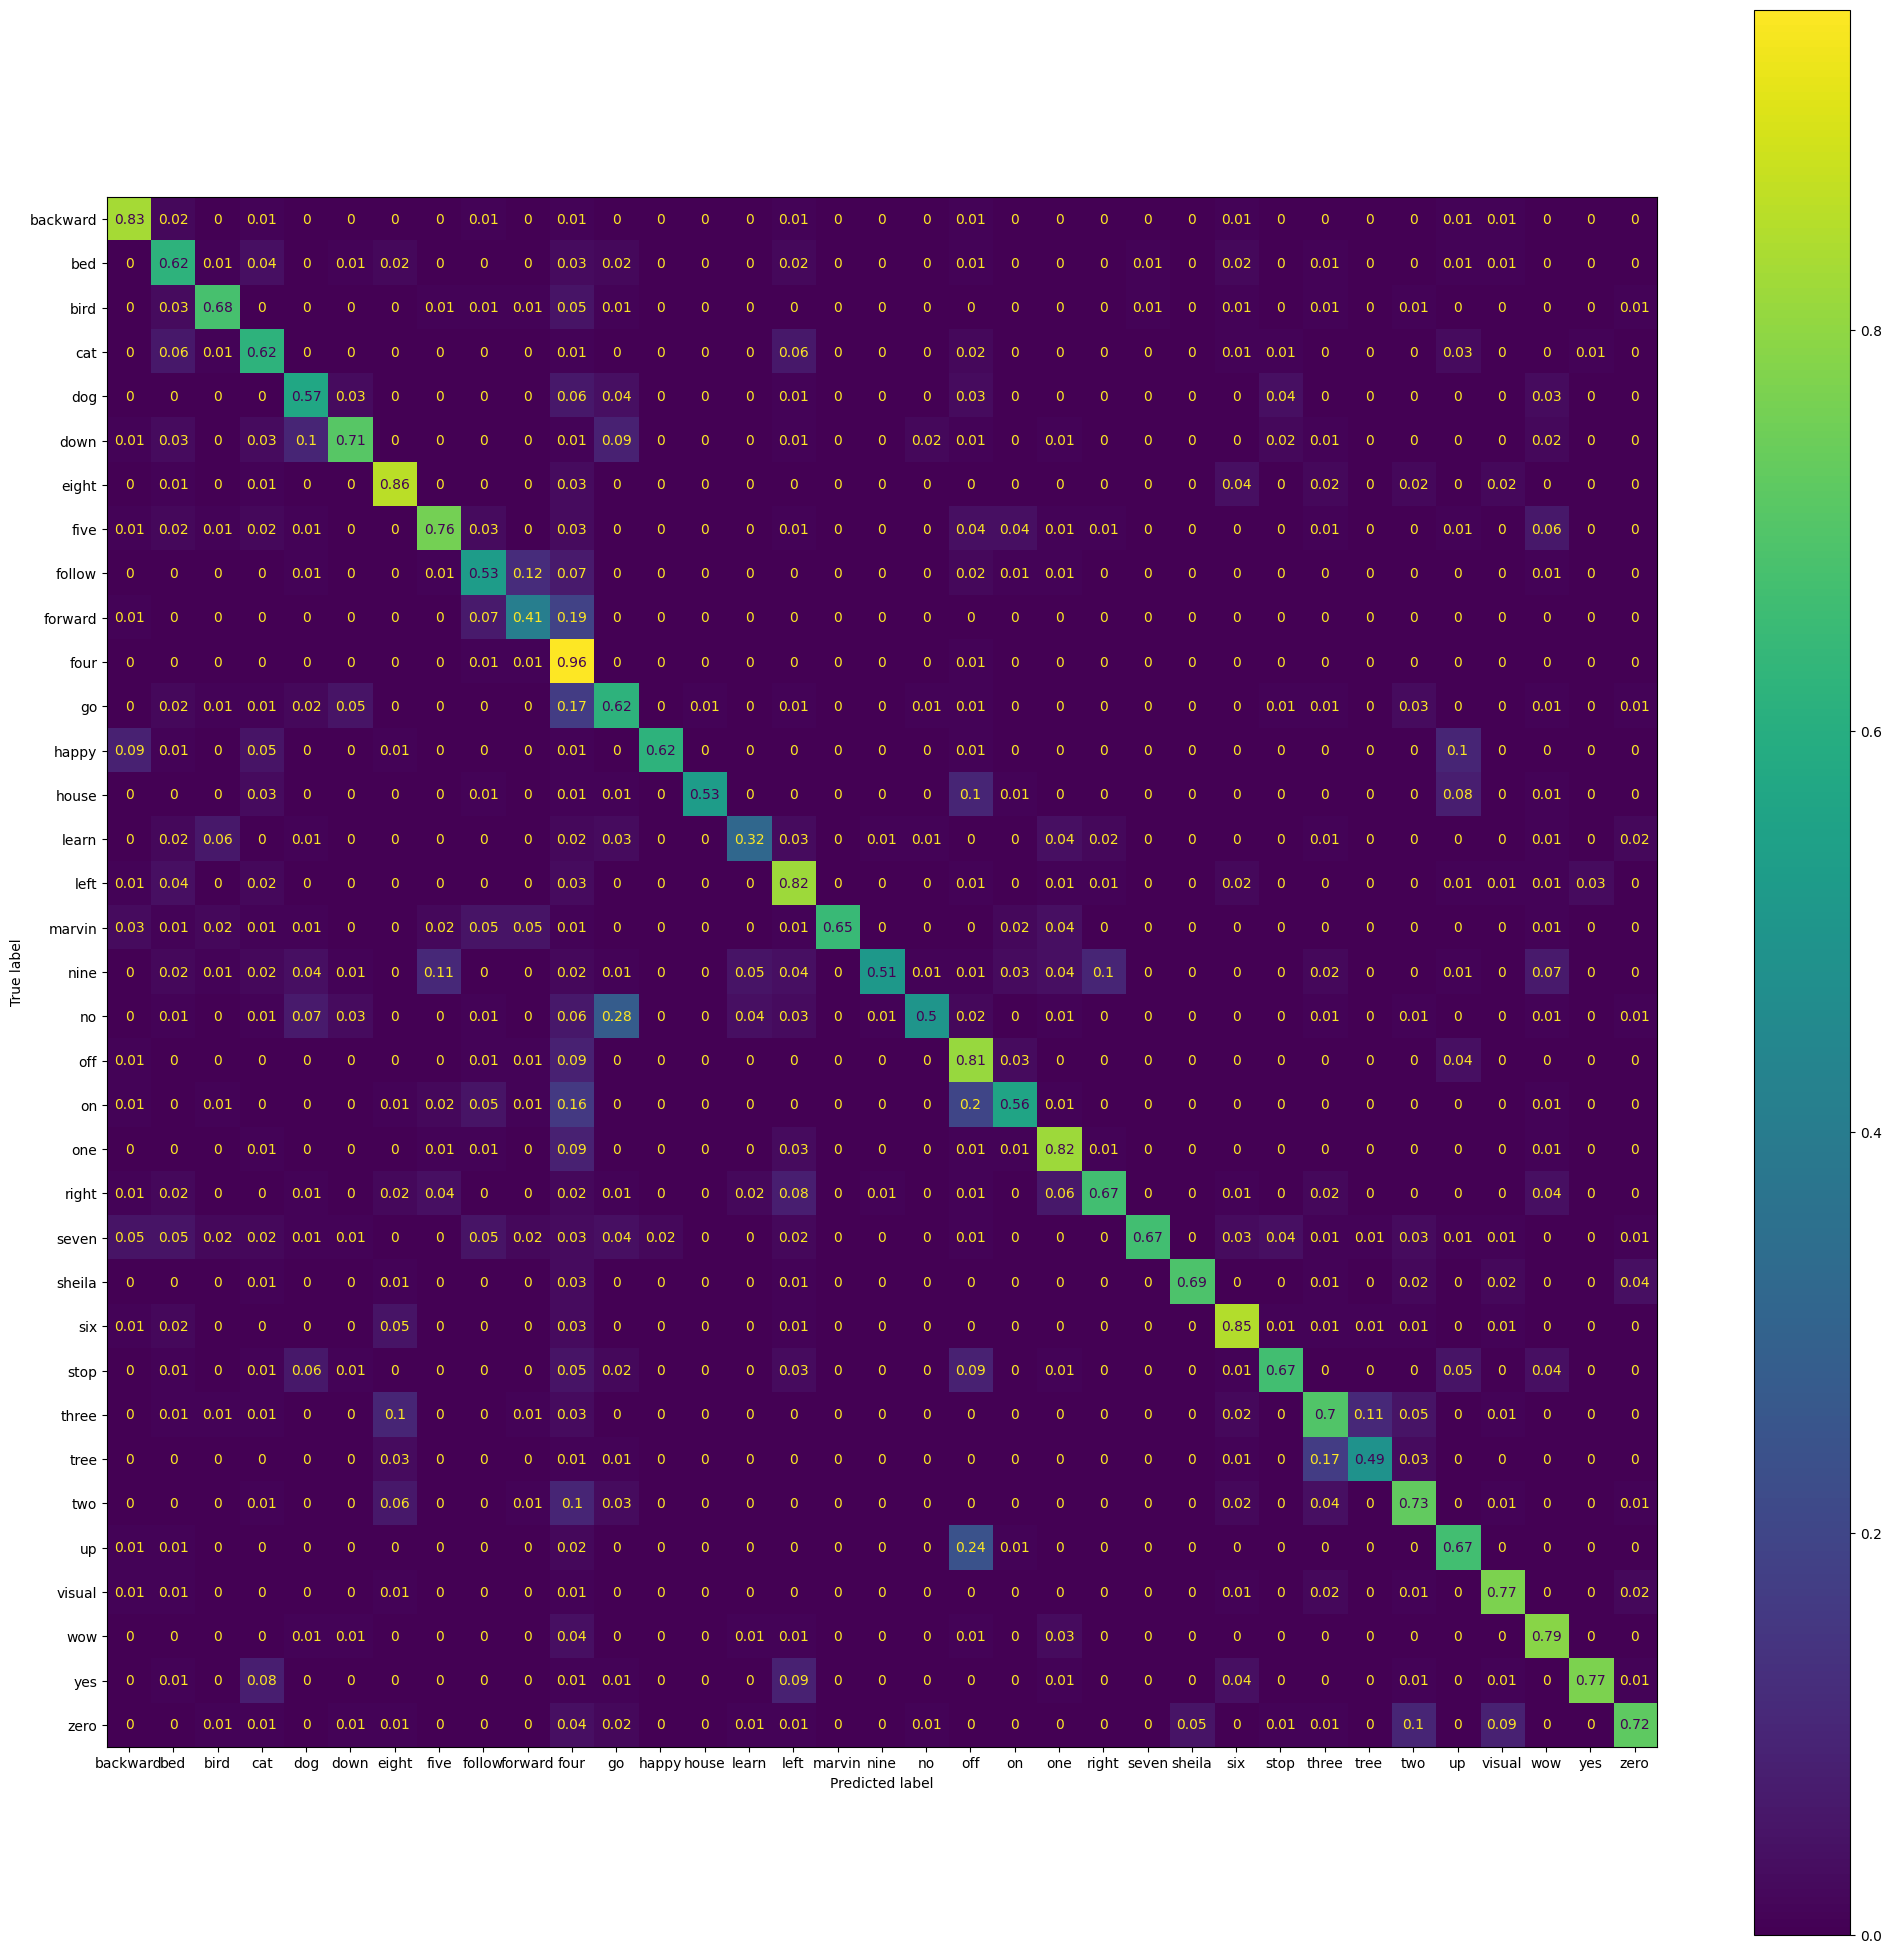

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 40, 99, 19)           190       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 10, 33, 19)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 33, 19)           3268      ['average_pooling2d[0][0]'

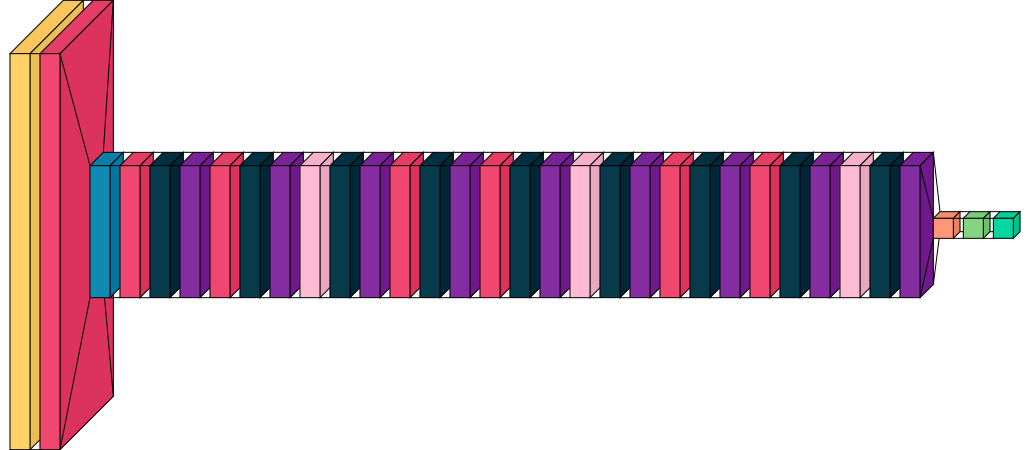

In [ ]:
tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

resnet8_m = resnet8(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(resnet8_m.summary())
visualkeras.layered_view(resnet8_m)

In [ ]:
resnet8_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_resnet8_m=resnet8_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 86s 168ms/step - loss: 2.7257 - sparse_categorical_accuracy: 0.2691 - val_loss: 4.7640 - val_sparse_categorical_accuracy: 0.0815
Epoch 2/25
497/497 [==============================] - 80s 161ms/step - loss: 1.7424 - sparse_categorical_accuracy: 0.5219 - val_loss: 4.6931 - val_sparse_categorical_accuracy: 0.1506
Epoch 3/25
497/497 [==============================] - 79s 159ms/step - loss: 1.3174 - sparse_categorical_accuracy: 0.6309 - val_loss: 2.4306 - val_sparse_categorical_accuracy: 0.3263
Epoch 4/25
497/497 [==============================] - 79s 159ms/step - loss: 1.1220 - sparse_categorical_accuracy: 0.6805 - val_loss: 2.5016 - val_sparse_categorical_accuracy: 0.3976
Epoch 5/25
497/497 [==============================] - 79s 158ms/step - loss: 1.0033 - sparse_categorical_accuracy: 0.7128 - val_loss: 18.1267 - val_sparse_categorical_accuracy: 0.0232
Epoch 6/25
497/497 [==============================] - 83s 167ms/step - loss: 0.9288 

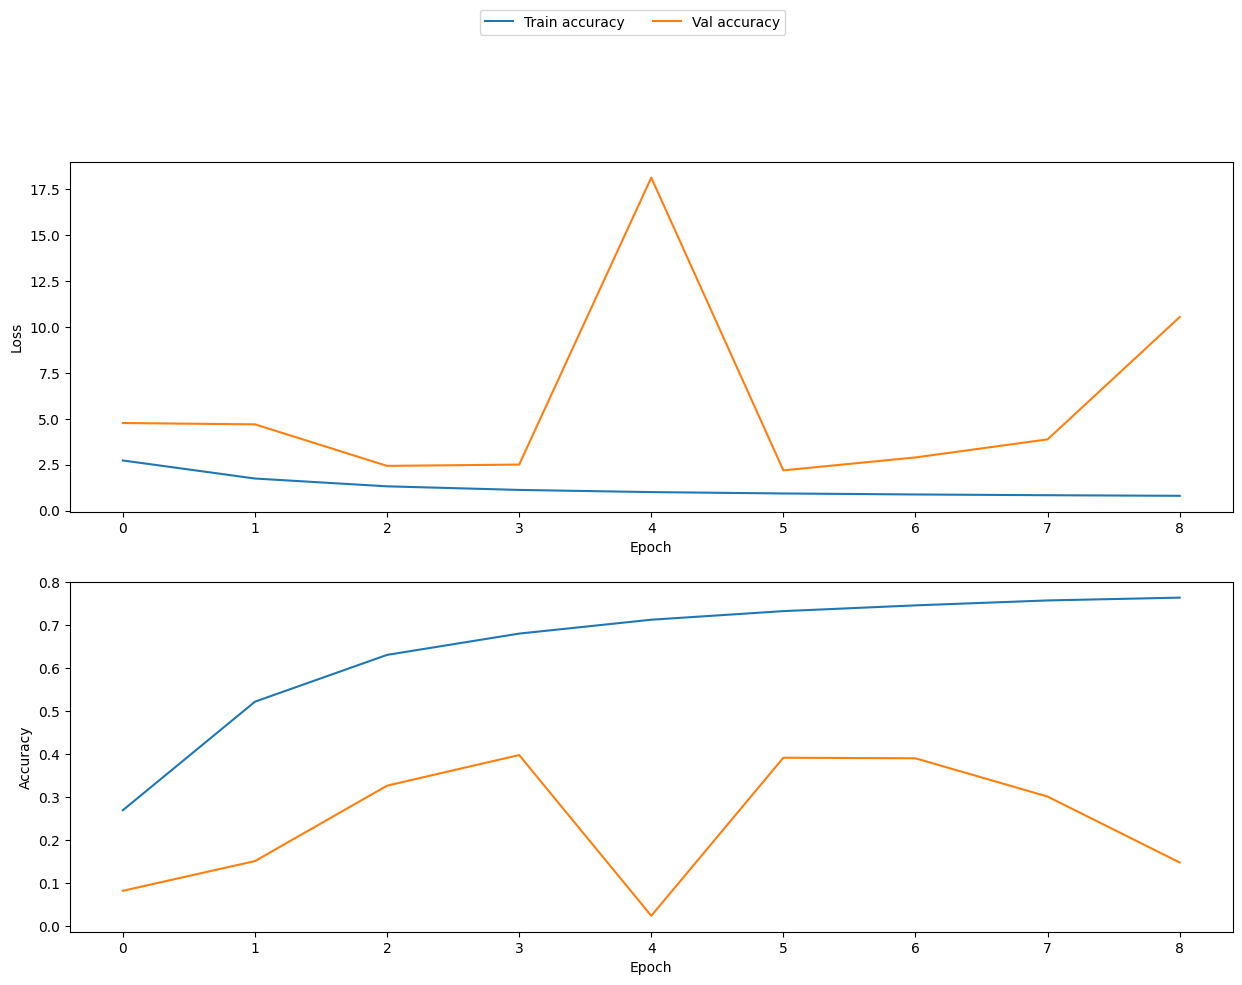

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_resnet8_m.history['loss'], label='Train loss')
axis[0].plot(history_resnet8_m.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_resnet8_m.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_resnet8_m.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
resnet8_m.save("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('resnet8_logf_noisy'))
#resnet8=tf.keras.saving.load_model("content/drive/MyDrive/HDA/models/logf_models/noisy_dataset/{}".format('resnet8_logf_noisy'))

In [ ]:

pred=resnet8_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{resnet8_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 8s 48ms/step


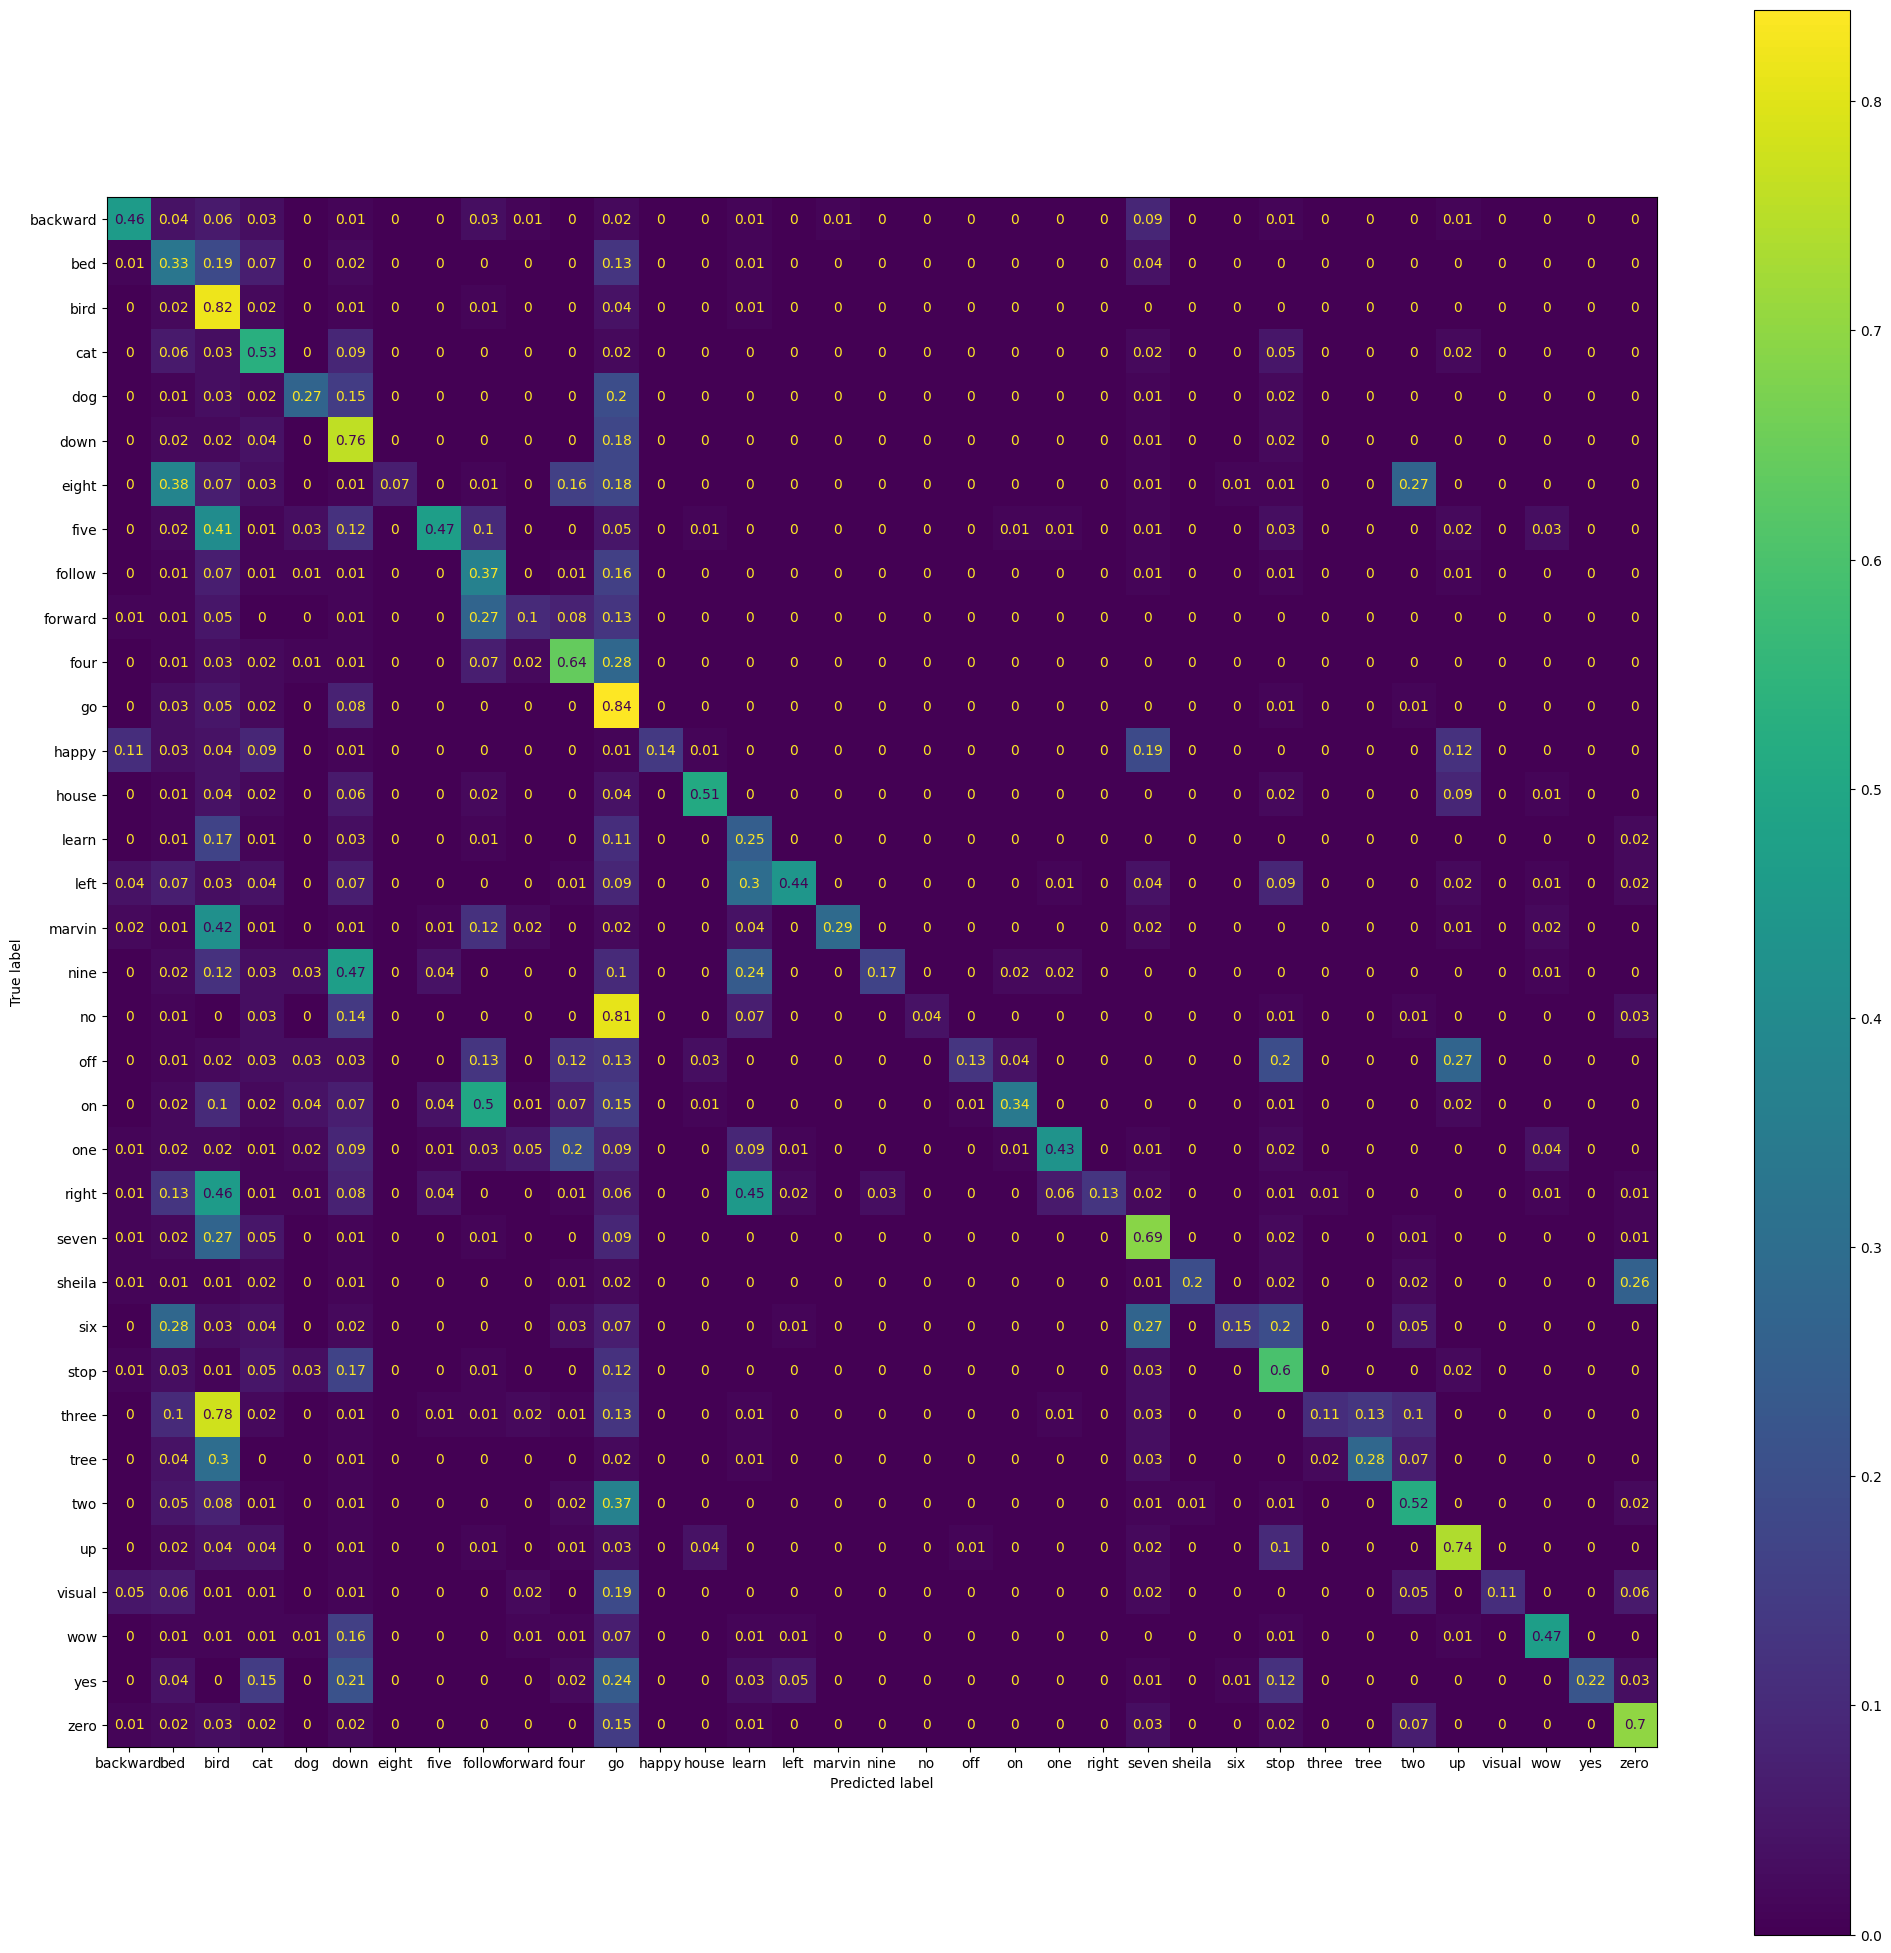

In [ ]:
fig, ax = plt.subplots(figsize=(25, 25))

cm=confusion_matrix(true_pred, pred_class)
cm=np.round(cm/cm.sum(axis=1),2)
disp=ConfusionMatrixDisplay(cm, display_labels=label_list)
disp.plot(ax=ax)

plt.show()

In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.640195,0.621359,0.638290,0.640195,0.628662,0.659183,0.640195,0.658575,0.640195,0.640195,0.621359,CNN_v3_m
1,0.690273,0.670744,0.694701,0.690273,0.685278,0.737047,0.690273,0.737675,0.690273,0.690273,0.670744,CNN_v2
2,0.393065,0.380701,0.383903,0.393065,0.374102,0.653238,0.393065,0.631576,0.393065,0.393065,0.380701,resnet8_m


**Experiment: remove Dropout hav**

In [ ]:
def custom_res_block(X, kernel_size, n_filter):

    X_1=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X)
    X_1=tf.keras.layers.Activation('relu')(X_1)
    X_1=tf.keras.layers.BatchNormalization()(X_1)

    X_2=tf.keras.layers.Conv2D(n_filter, kernel_size=kernel_size, dilation_rate=(2,2) ,padding='same')(X_1)
    X_2=tf.keras.layers.Activation('relu')(X_2)
    X_2=tf.keras.layers.BatchNormalization()(X_2)

    out = tf.keras.layers.Add()([X_1, X_2])
    out=tf.keras.layers.Activation('relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)

    return out



def CNN_v3(input_shape, output_shape):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the output size is the number of output label that the model will predict
    """
    X_input=keras.Input(input_shape)

    X=tf.keras.layers.Conv2D(8, kernel_size=(4,4), padding='same')(X_input)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.AveragePooling2D((3,3), strides=(2,3))(X)
    X=tf.keras.layers.BatchNormalization()(X)

    #X=tf.keras.layers.Dropout(0.2)(X)

    X=custom_res_block(X, (2,3), 16)

    X=tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(2,3), padding='same')(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    X=tf.keras.layers.GlobalAveragePooling2D()(X)

    X=tf.keras.layers.Flatten()(X)

    X=tf.keras.layers.Dense(units=128)(X)
    X=tf.keras.layers.Activation('relu')(X)
    X=tf.keras.layers.BatchNormalization()(X)

    #X=tf.keras.layers.Dropout(0.2)(X)

    X_final=tf.keras.layers.Dense(output_shape, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X_final)

    return model

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import keras

tf.config.run_functions_eagerly(True)

img_shape=(40,99,1)

CNN_v3_m = CNN_v3(img_shape, len(label_list))

optimizer = tf.keras.optimizers.Adam()

print(CNN_v3_m.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 40, 99, 1)]          0         []                            
                                                                                                  
 conv2d_8 (Conv2D)           (None, 40, 99, 8)            136       ['input_3[0][0]']             
                                                                                                  
 activation_12 (Activation)  (None, 40, 99, 8)            0         ['conv2d_8[0][0]']            
                                                                                                  
 average_pooling2d_2 (Avera  (None, 19, 33, 8)            0         ['activation_12[0][0]']       
 gePooling2D)                                                                               

In [ ]:
CNN_v3_m.compile(optimizer=optimizer, run_eagerly = True, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

history_cv_3=CNN_v3_m.fit(train_set, batch_size=batch_size, epochs=25,
              steps_per_epoch=train_steps, validation_data=validation_set,
              validation_steps=validation_steps, callbacks=callbacks)

Epoch 1/25
497/497 [==============================] - 375s 283ms/step - loss: 2.1306 - sparse_categorical_accuracy: 0.4159 - val_loss: 2.6433 - val_sparse_categorical_accuracy: 0.2619
Epoch 2/25
497/497 [==============================] - 64s 128ms/step - loss: 0.9435 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.9193 - val_sparse_categorical_accuracy: 0.7313
Epoch 3/25
497/497 [==============================] - 63s 127ms/step - loss: 0.7128 - sparse_categorical_accuracy: 0.7929 - val_loss: 0.7530 - val_sparse_categorical_accuracy: 0.7813
Epoch 4/25
497/497 [==============================] - 63s 126ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.8218 - val_loss: 0.7569 - val_sparse_categorical_accuracy: 0.7770
Epoch 5/25
497/497 [==============================] - 62s 125ms/step - loss: 0.5469 - sparse_categorical_accuracy: 0.8376 - val_loss: 0.9831 - val_sparse_categorical_accuracy: 0.7302
Epoch 6/25
497/497 [==============================] - 62s 124ms/step - loss: 0.5121 

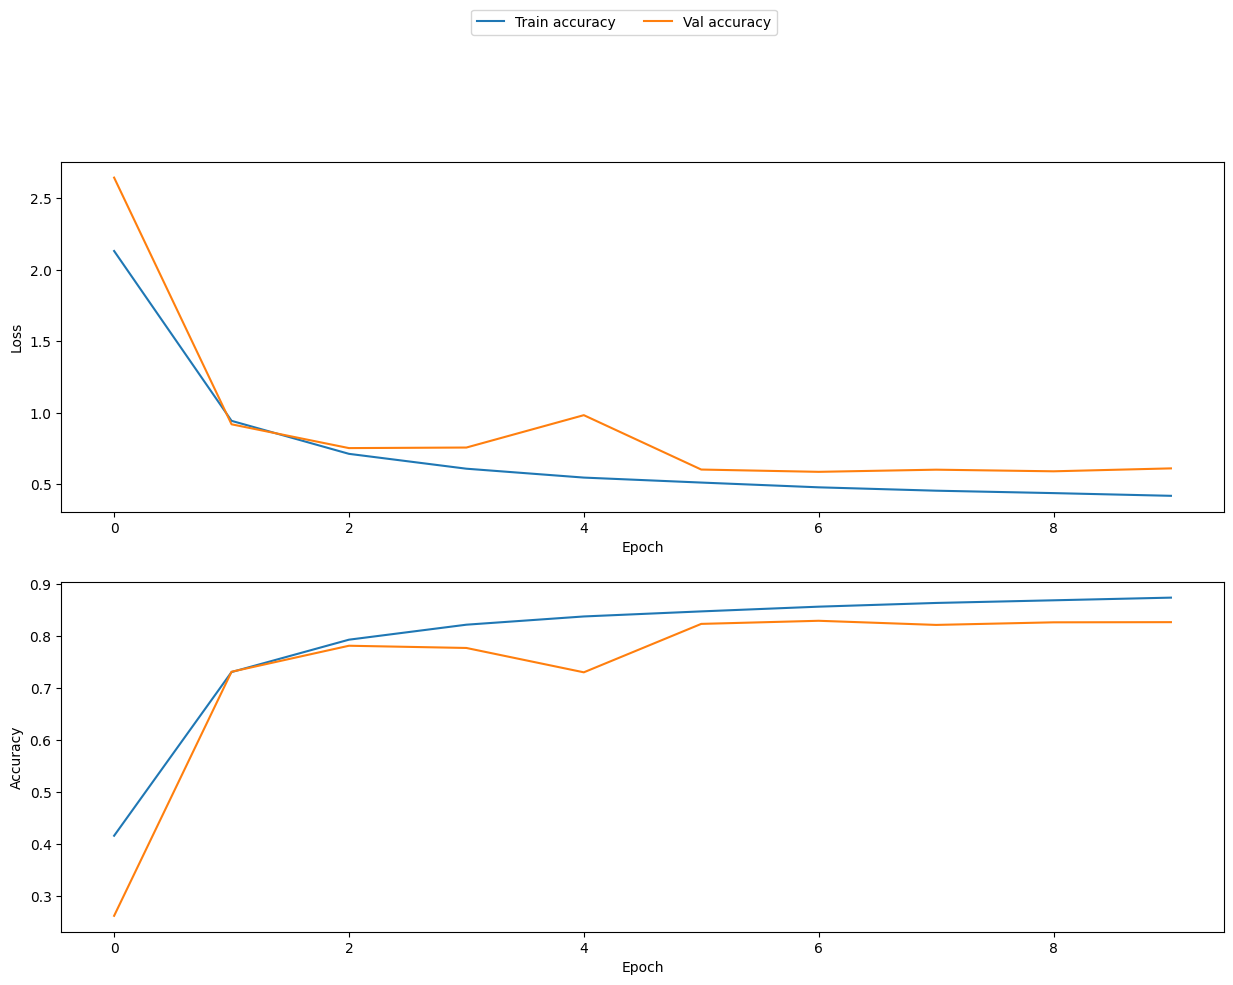

In [ ]:
figure, axis = plt.subplots(2,1,figsize=(15,10))
axis[0].plot(history_cv_3.history['loss'], label='Train loss')
axis[0].plot(history_cv_3.history['val_loss'], label='Val loss')
axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Loss')

axis[1].plot(history_cv_3.history['sparse_categorical_accuracy'], label='Train accuracy')
axis[1].plot(history_cv_3.history['val_sparse_categorical_accuracy'], label='Val accuracy')
axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('Accuracy')

plt.legend(bbox_to_anchor=(0.5, 1), loc="lower center", bbox_transform=figure.transFigure, ncol=3)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score

perform={}

perform["accuracy"]=[]
perform["balanced_accuracy"]=[]

perform["f1_score_weighted"]=[]
perform["f1_score_micro"]=[]
perform["f1_score_macro"]=[]

perform["precision_score_weighted"]=[]
perform["precision_score_micro"]=[]
perform["precision_score_macro"]=[]

perform["recall_score_weighted"]=[]
perform["recall_score_micro"]=[]
perform["recall_score_macro"]=[]
perform['model']=[]

pred=CNN_v3_m.predict(test_set)
pred_class=pred.argmax(axis=1)
true_pred=test_set_label.argmax(axis=1)


perform['model'].append(f'{CNN_v3_m=}'.split('=')[0])
perform['accuracy'].append(accuracy_score(true_pred, pred_class))
perform['balanced_accuracy'].append(balanced_accuracy_score(true_pred, pred_class))
perform['f1_score_micro'].append(f1_score(true_pred, pred_class, average='micro'))
perform['f1_score_macro'].append(f1_score(true_pred, pred_class, average='macro'))
perform['f1_score_weighted'].append(f1_score(true_pred, pred_class, average='weighted'))

perform['precision_score_micro'].append(precision_score(true_pred, pred_class, average='micro'))
perform['precision_score_macro'].append(precision_score(true_pred, pred_class, average='macro'))
perform['precision_score_weighted'].append(precision_score(true_pred, pred_class, average='weighted'))

perform["recall_score_micro"].append(recall_score(true_pred, pred_class, average='micro'))
perform["recall_score_macro"].append(recall_score(true_pred, pred_class, average='macro'))
perform["recall_score_weighted"].append(recall_score(true_pred, pred_class, average='weighted'))


166/166 [==============================] - 6s 38ms/step


In [ ]:
pd.DataFrame(perform)

,accuracy,balanced_accuracy,f1_score_weighted,f1_score_micro,f1_score_macro,precision_score_weighted,precision_score_micro,precision_score_macro,recall_score_weighted,recall_score_micro,recall_score_macro,model
0,0.82742,0.810163,0.825812,0.82742,0.81583,0.835539,0.82742,0.833397,0.82742,0.82742,0.810163,CNN_v3_m
